# 0. Description

## 0.1 Description Data Recieved

Description Data Recieved

The solutions are evaluated on two criteria: predicted future Index values and allocated energy from a newly discovered star

1) Index predictions are evaluated using RMSE metric

2) Energy allocation is also evaluated using RMSE metric and has a set of known factors that need to be taken into account.

Every galaxy has a certain limited potential for improvement in the index described by the following function:

Potential for increase in the Index = -np.log(Index+0.01)+3

Likely index increase dependent on potential for improvement and on extra energy availability is described by the following function:

Likely increase in the Index = extra energy * Potential for increase in the Index **2 / 1000

There are also several constraints:

in total there are 50000 zillion DSML available for allocation and no galaxy at a point in time should be allocated more than 100 zillion DSML or less than 0 zillion DSML. Galaxies with low existence expectancy index below 0.7 should be allocated at least 10% of the total energy available in the foreseeable future

3) Leaderboard is based on a combined scaled metric:

80% prediction task RMSE + 20% optimization task RMSE * lambda where lambda is a normalizing factor

4) Leaderboard is 80% public and 20% private

5) The submission should be in the following format:

## 0.2 Useful answers from slack

**Q: Jonathan Whitaker**

Can I ask for clarification on the formula:
Likely increase in the Index = extra energy * Potential for increase in the Index **2 / 1000
Is it :

(1) Likely increase in the Index = extra energy * Potential for increase in the Index **(2 / 1000)

(2) Likely increase in the Index = extra energy * (Potential for increase in the Index **2) / 1000


**A: Kabir Abdulmajeed**

*Using a pythonic interpretation, should be (2)*

**C: Jonathan Whitaker**

*For the optimization part I'm allocating in proportion to (potential for increase **2), clipping to 100 and fudging slightly to get 10% to LE galaxies. So nothing fancy - this seemed OK and let me compare prediction approaches.
I think the optimization part does affect the score quite a lot - I've seen a few folks with very low RMSE in testing, but scores still ~0.1 on the leaderboard. Would be interested to hear if anyone has tips on it :slightly_smiling_face:*
```
Not worth keeping secret - I'm sure it can be improved!! But here's the code for what it's worth:
test['pred_y_cat2'] = model.predict(test[cols].fillna(0))
test['potential_increase'] = -np.log(test['pred_y_cat2']+0.01)+3
ss = pd.DataFrame({
    'Index':test.index,
    'pred':test['pred_y_cat2'],
    'opt_pred':0,
    'eei':test['existence expectancy index'], # So we can split into low and high EEI galaxies
    'potential_increase':test['potential_increase'],
    'p2':test['potential_increase']**2
})
# Weight by p2
ss['opt_pred'] = (ss['p2']*50000/ss['p2'].sum()).clip(0, 100)
# Rescale to get 5k to low-EEI
low_sum = ss.loc[ss.eei < 0.7, 'opt_pred'].sum()
ss.loc[ss.eei < 0.7, 'opt_pred'] = (ss.loc[ss.eei < 0.7, 'opt_pred']*5001/low_sum).clip(0, 100) # Fudge it above 5000
high_sum = ss.loc[ss.eei >= 0.7, 'opt_pred'].sum()
ss.loc[ss.eei >= 0.7, 'opt_pred'] = (ss.loc[ss.eei >= 0.7, 'opt_pred']*44600/high_sum).clip(0, 100) # Tweak to keep total below 50k
increase = (ss['opt_pred']*ss['potential_increase']**2)/1000
print(sum(increase), ss.loc[ss.eei < 0.7, 'opt_pred'].sum(), ss['opt_pred'].sum())
ss[['Index', 'pred', 'opt_pred']].to_csv('submission.csv', index=False)
```

**C: Jonathan Whitaker**

*Looking at the years sequentially, you can get a decent score just by fitting the curve over time. Score of 0.79 (14th place) using no features besides the year, doing a separate model (GAM with a basic spline) for each galaxy.*
https://monosnap.com/file/LicoEdUnNRQv0FQvzsFqLRmuQne0cs

# 1. Importing data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submit = pd.read_csv('sample_submit.csv')

## 1.1 Train dataset

In [2]:
train_df

galactic year                        galaxy  existence expectancy index  \
0            990025  Large Magellanic Cloud (LMC)                    0.628657   
1            990025              Camelopardalis B                    0.818082   
2            990025                       Virgo I                    0.659443   
3            990025            UGC 8651 (DDO 181)                    0.555862   
4            990025                  Tucana Dwarf                    0.991196   
...             ...                           ...                         ...   
3860        1015056                     Columba I                    1.029704   
3861        1015056  Leo II Dwarf (Leo B, DDO 93)                    0.937869   
3862        1015056        Canes Venatici I Dwarf                    1.036144   
3863        1015056                         KKs 3                    0.939034   
3864        1015056                      NGC 5237                    1.032244   

      existence expectancy at birth  Gross income per capita  Income Index  \
0                         63.125200             27109.234310      0.646039   
1                         81.004994             30166.793958      0.852246   
2                         59.570534              8441.707353      0.499762   
3                         52.333293                      NaN           NaN   
4                         81.802464             81033.956906      1.131163   
...                             ...                      ...           ...   
3860                      82.832063             34310.471408      0.855094   
3861                      75.877098             36899.067719      0.929494   
3862                      93.540275             37002.977875      1.085245   
3863                      78.274427             28180.459770      0.687655   
3864                      91.641356             73109.215949      1.207746   

      Expected years of education (galactic years)  \
0                                         8.240543   
1                                        10.671823   
2                                         8.840316   
3                                              NaN   
4                                        13.800672   
...                                            ...   
3860                                     18.578586   
3861                                     16.153857   
3862                                     21.066473   
3863                                      9.388911   
3864                                     18.910920   

      Mean years of education (galactic years)  \
0                                          NaN   
1                                     4.742470   
2                                     5.583973   
3                                          NaN   
4                                    13.188907   
...                                        ...   
3860                                 10.557143   
3861                                  9.151665   
3862                                 16.661344   
3863                                  8.908748   
3864                                 16.202486   

      Intergalactic Development Index (IDI)  Education Index  ...  \
0                                       NaN              NaN  ...   
1                                  0.833624         0.467873  ...   
2                                  0.469110         0.363837  ...   
3                                       NaN              NaN  ...   
4                                  0.910341         0.918353  ...   
...                                     ...              ...  ...   
3860                               0.906573         0.862826  ...   
3861                               0.865822         0.747577  ...   
3862                               0.983835         1.100779  ...   
3863                               0.735694         0.602703  ...   
3864                               1.171634         1.085080  ...   

      Intergalact

## 1.2 Test dataset

In [3]:
test_df

galactic year                galaxy  existence expectancy index  \
0          1007012               KK98 77                    0.456086   
1          1007012         Reticulum III                    0.529835   
2          1008016         Reticulum III                    0.560976   
3          1007012               Segue 1                    0.565910   
4          1013042               Virgo I                    0.588274   
..             ...                   ...                         ...   
885        1016064  ESO 383-087 (ISG 39)                         NaN   
886        1016064               NGC 247                         NaN   
887        1016064            ESO 325-11                         NaN   
888        1016064           ESO 540-032                         NaN   
889        1016064               KK98 77                         NaN   

     existence expectancy at birth  Gross income per capita  Income Index  \
0                        51.562543             12236.576447      0.593325   
1                        57.228262              3431.883825      0.675407   
2                        59.379539             27562.914252      0.594624   
3                        59.952390             20352.232905      0.837700   
4                        55.428320             23959.704016      0.520579   
..                             ...                      ...           ...   
885                            NaN                      NaN           NaN   
886                            NaN                      NaN           NaN   
887                            NaN                      NaN           NaN   
888                            NaN                      NaN           NaN   
889                            NaN                      NaN           NaN   

     Expected years of education (galactic years)  \
0                                       10.414164   
1                                        7.239485   
2                                       11.774890   
3                                       11.613621   
4                                       10.392416   
..                                            ...   
885                                           NaN   
886                                           NaN   
887                                           NaN   
888                                           NaN   
889                                           NaN   

     Mean years of education (galactic years)  \
0                                   10.699072   
1                                    5.311122   
2                                    5.937797   
3                                   10.067882   
4                                    6.374637   
..                                        ...   
885                                       NaN   
886                                       NaN   
887                                       NaN   
888                                       NaN   
889                                       NaN   

     Intergalactic Development Index (IDI)  Education Index  ...  \
0                                 0.547114         0.556267  ...   
1                                 0.497688         0.409969  ...   
2                                 0.544744         0.486167  ...   
3                                 0.691641         0.523441  ...   
4                                 0.530676         0.580418  ...   
..                                     ...              ...  ...   
885                                    NaN              NaN  ...   
886                                    NaN              NaN  ...   
887                                    NaN              NaN  ...   
888                                    NaN              NaN  ...   
889                                    NaN              NaN  ...   

     Current health expenditure (% of GGP)  \
0                                      NaN   
1                                      NaN   
2                                 

In [4]:
print('The shape of our training set: ',train_df.shape[0], 'rows', 'and', train_df.shape[1], 'features')
print('The shape of our testing set: ',test_df.shape[0], 'tows', 'and', test_df.shape[1], 'features')

The shape of our training set:  3865 rows and 80 features
The shape of our testing set:  890 tows and 79 features


The testing set has 1 feature less than the training set, which is **y (index of interest)**, the target to predict.

## 1.3 Sample submission

In [5]:
sample_submit

index  pred  opt_pred
0        0  0.08       100
1        1  0.08       100
2        2  0.08       100
3        3  0.08       100
4        4  0.08       100
..     ...   ...       ...
885    885  0.08        10
886    886  0.08        10
887    887  0.08        10
888    888  0.08        10
889    889  0.08        10

[890 rows x 3 columns]

Total sum of resources allocation in sample submission:

In [6]:
sample_submit.opt_pred.sum()

45900

# 1. EDA

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
sns.set_style('whitegrid')

from utils import plot_timeline

## 1.1 Correlation with target

Let's analyse numerical features correlation with **y**:

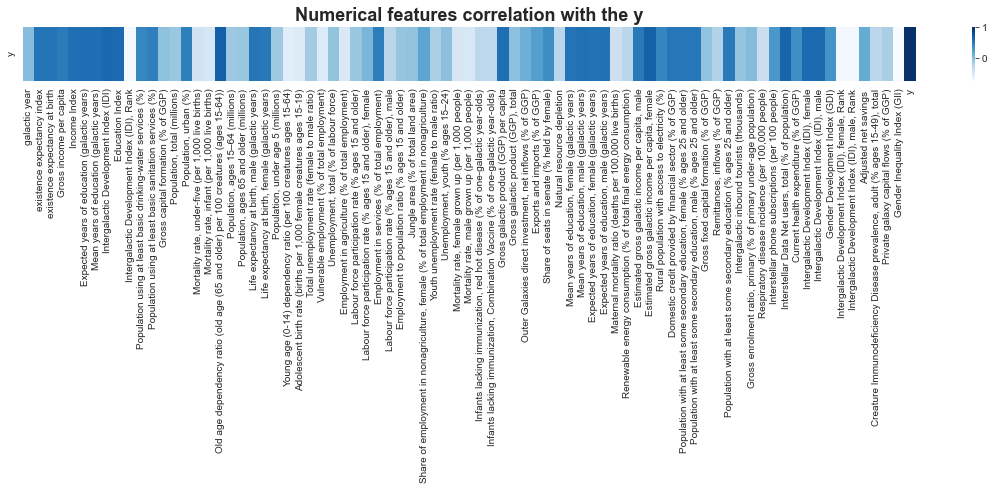

In [8]:
def num_corr_with_target(df, target_col):
    num=df.select_dtypes(exclude='object')
    numcorr=num.corr()
    f,ax=plt.subplots(figsize=(20,1))
    sns.heatmap(numcorr.sort_values(by=[target_col], ascending=False).head(1), cmap='Blues')
    plt.title("Numerical features correlation with the y", weight='bold', fontsize=18)
    plt.show()
    return numcorr

num_corr_with_y = num_corr_with_target(train_df, 'y')

And the same in descending order:

In [9]:
Num=num_corr_with_y['y'].sort_values(ascending=False).to_frame()

cm = sns.light_palette("cyan", as_cmap=True)

s = Num.style.background_gradient(cmap=cm)
s

In [10]:
Num.index.values[:30]

array(['y',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Estimated gross galactic income per capita, female',
       'Interstellar Data Net users, total (% of population)',
       'Intergalactic Development Index (IDI)',
       'Intergalactic Development Index (IDI), male',
       'Intergalactic Development Index (IDI), female', 'Education Index',
       'Expected years of education (galactic years)',
       'Mean years of education (galactic years)', 'Income Index',
       'Gross galactic product (GGP) per capita',
       'Mean years of education, male (galactic years)',
       'Expected years of education, male (galactic years)',
       'Expected years of education, female (galactic years)',
       'existence expectancy at birth',
       'Mean years of education, female (galactic years)',
       'existence expectancy index',
       'Life expectancy at birth, male (galactic years)',
       'Domestic credit provided by financial sec

## 1.2 Missing values on train

### 1.2.1 Missing values average per columns

Let's figure out picture for missing values:

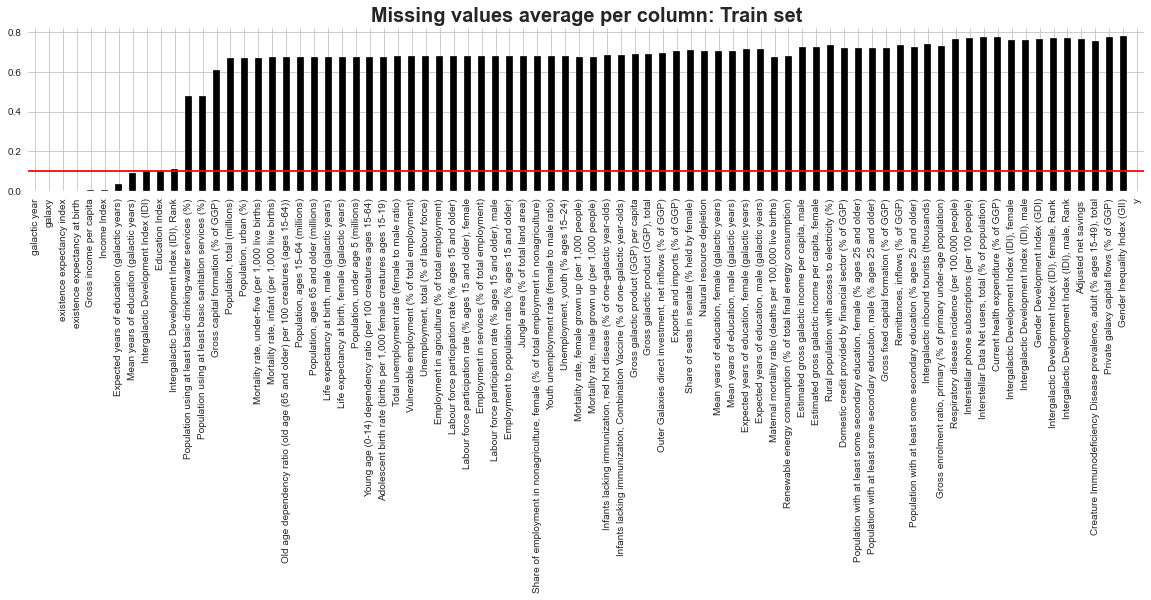

In [11]:
plt.style.use('seaborn')
sns.set_style('whitegrid')

plt.subplots(0,0,figsize=(20,3))

train_df.isnull().mean().plot.bar(color='black')
plt.axhline(y=0.1, color='r', linestyle='-')
plt.title('Missing values average per column: Train set', fontsize=20, weight='bold' )
plt.show()


**Most features have more than 50 percent gaps.** Let's look at their distribution across the rows.

### 1.2.2 Missing values matrix

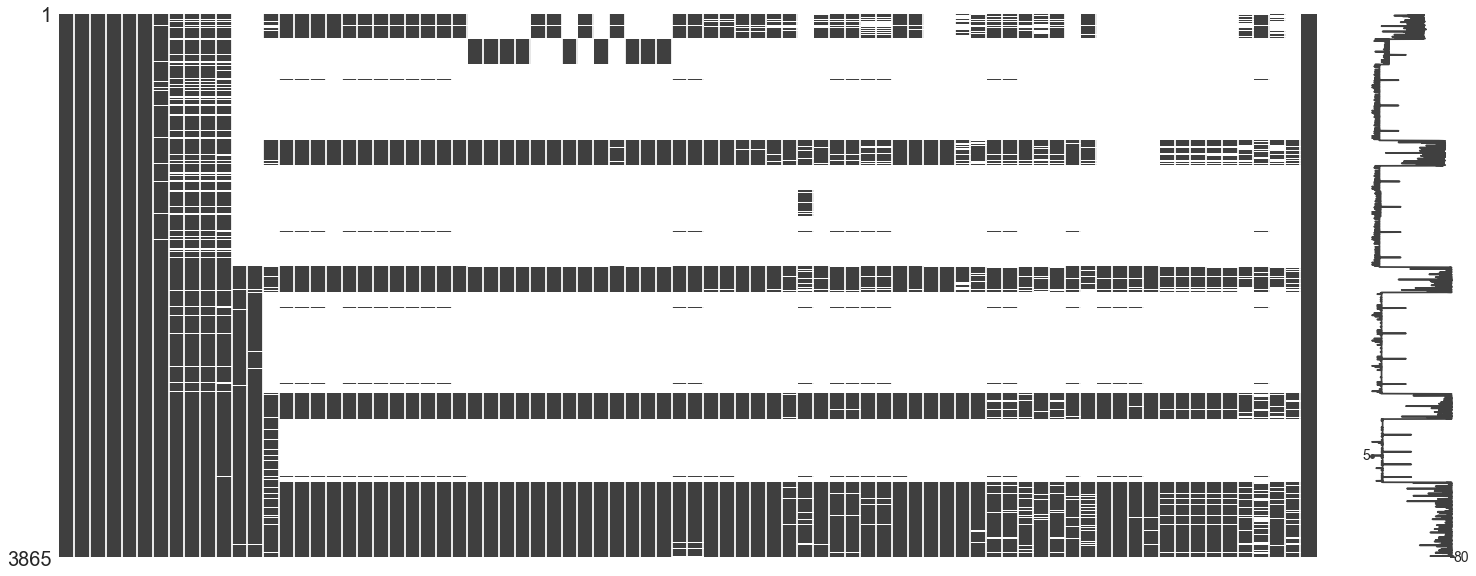

In [12]:
msno.matrix(train_df.sort_values(by = ['galactic year', 'galaxy']))

**It can be seen that there are several rows in the data set with very good data quality. In contrast, there are rows in which stably most of the columns are almost empty. Moreover, they are arranged in series. Probably this pattern was due to the unstable process of transmitting information.**

**At the same time, some of the columns have consistently high data quality on all rows.** 

The next 11 columns are filled in almost all rows:

In [13]:
train_high_filled_columns_df = pd.DataFrame(train_df[train_df.columns[0:11].values].isna().mean(), 
             columns = ['missing_frac']).join(Num)
train_high_filled_columns_df

missing_frac         y
galactic year                                     0.000000  0.019264
galaxy                                            0.000000       NaN
existence expectancy index                        0.000259  0.547397
existence expectancy at birth                     0.000259  0.555757
Gross income per capita                           0.007245  0.508029
Income Index                                      0.007245  0.579969
Expected years of education (galactic years)      0.034411  0.584069
Mean years of education (galactic years)          0.093920  0.583858
Intergalactic Development Index (IDI)             0.101164  0.625114
Education Index                                   0.101164  0.613938
Intergalactic Development Index (IDI), Rank       0.112031 -0.681592

In [14]:
train_high_filled_columns = train_high_filled_columns_df.index
train_high_filled_columns

Index(['galactic year', 'galaxy', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index', 'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank'],
      dtype='object')

The next 2 columns are filled in about 50 percent of the rows:

In [15]:
pd.DataFrame(train_df[train_df.columns[12:14].values].isna().mean(), 
             columns = ['missing_frac']).join(Num)

missing_frac         y
Population using at least basic sanitation serv...      0.478655  0.480033
Gross capital formation (% of GGP)                      0.611384 -0.014672

And the last one which is filled in about 30 percent of the rows:

In [16]:
pd.DataFrame(train_df[train_df.columns[14:15].values].isna().mean(), 
             columns = ['missing_frac']).join(Num)

missing_frac         y
Population, total (millions)      0.671151 -0.058438

**Ideas**: 

1. We can create and stack 3 models with different training data regions:

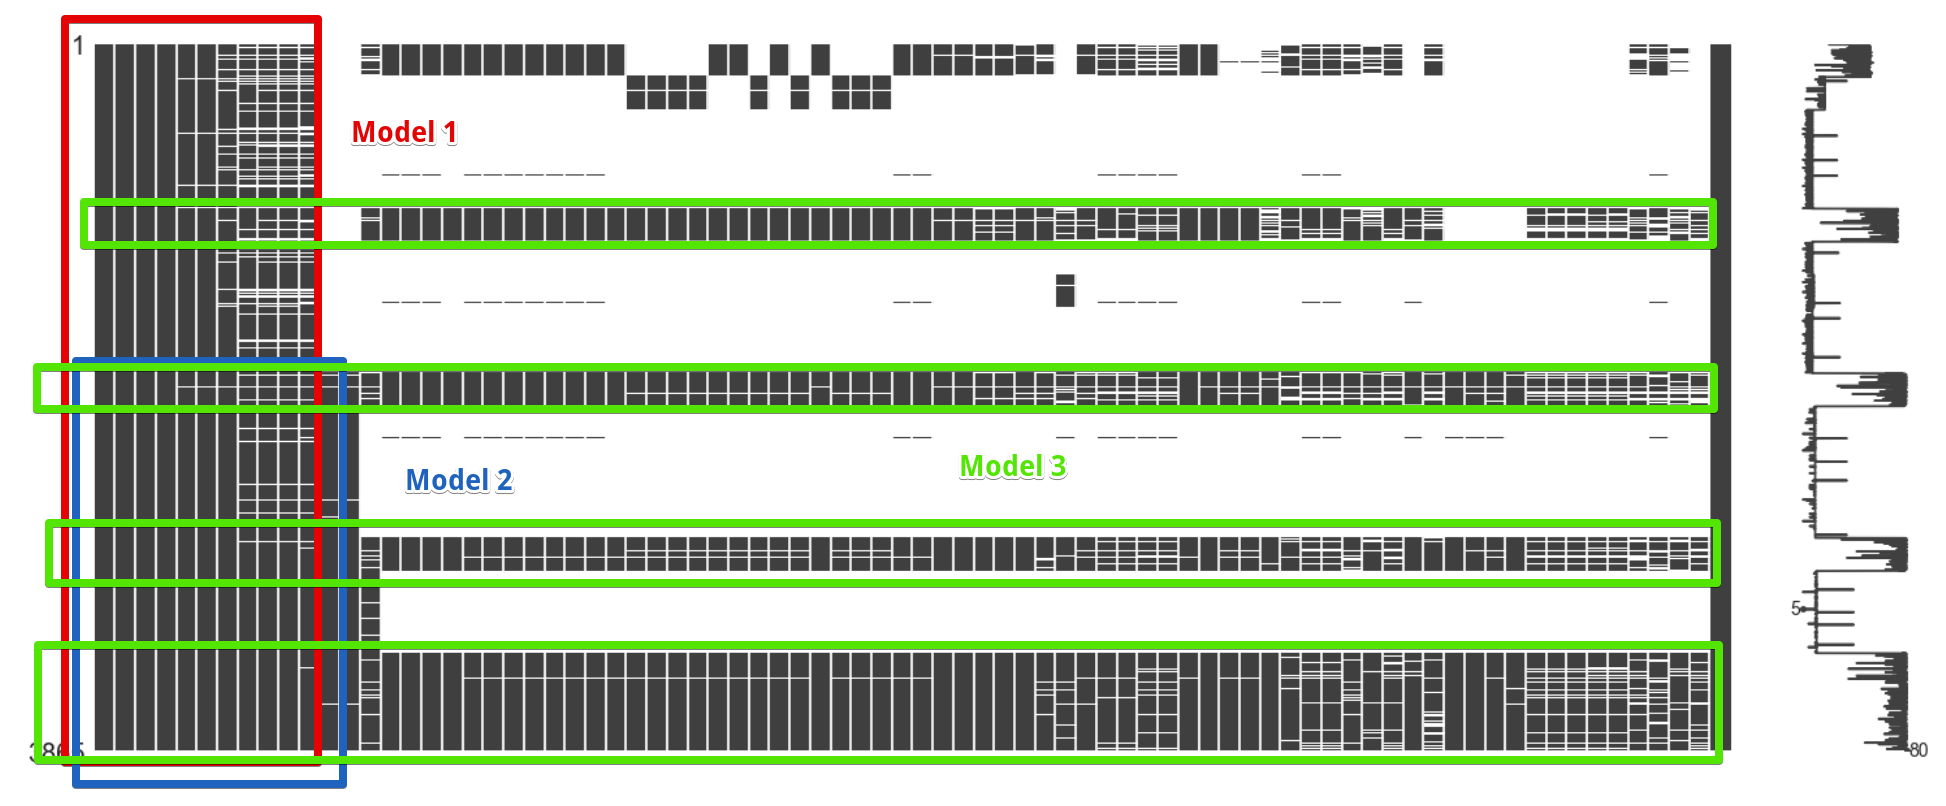

2. Inside each of the three regions we can use IterativeImputer for filling missing values.

### 1.2.3 Missing values are chronological?

Let's find out if the distribution of missing values is in correlation with galactic year:

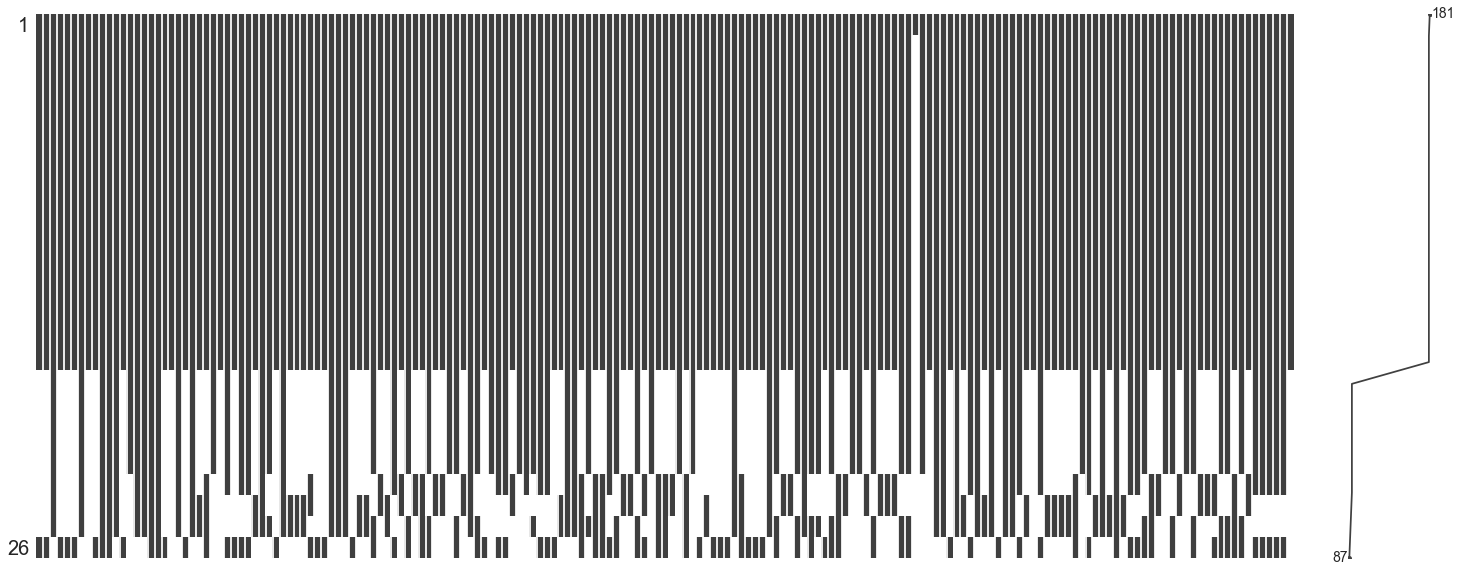

In [17]:
msno.matrix(train_df.pivot(index = 'galactic year', 
               columns = 'galaxy', 
               values='y') \
            .sort_values(by = 'galactic year')
           )

**All missing values chronologically at the end of the measurement history!** It means that galactic year is very strong feature. We can try to predict y with just one feature in each galaxy separately.

## 1.3 Missing values on test

<Figure size 1440x216 with 0 Axes>

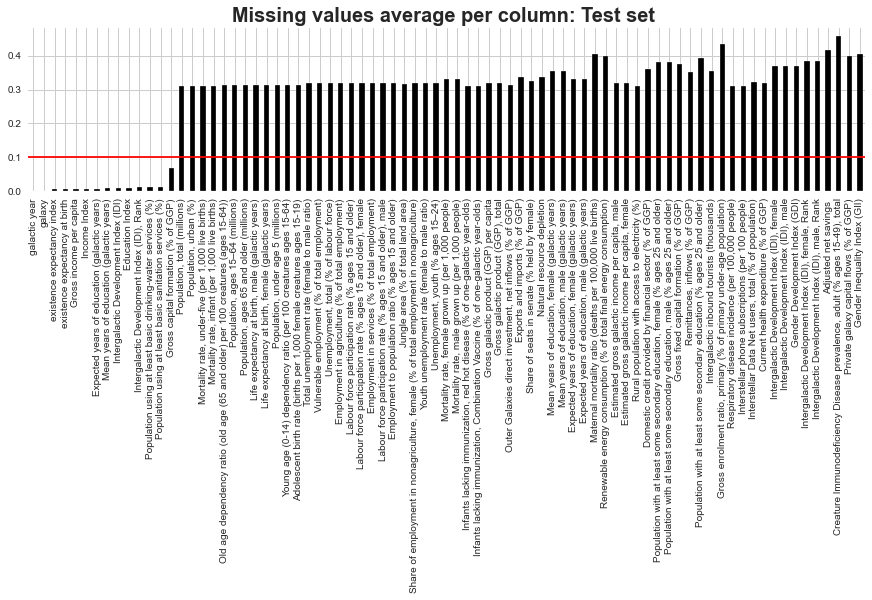

In [18]:
plt.style.use('seaborn')
sns.set_style('whitegrid')

plt.subplots(0,0,figsize=(20,3))


plt.subplots(1,0,figsize=(15,3))
test_df.isnull().mean().plot.bar(color='black')
plt.axhline(y=0.1, color='r', linestyle='-')
plt.title('Missing values average per column: Test set ', fontsize=20, weight='bold' )
plt.show()

**Also a very high percentage of missing data.** Let's find out the pattern:

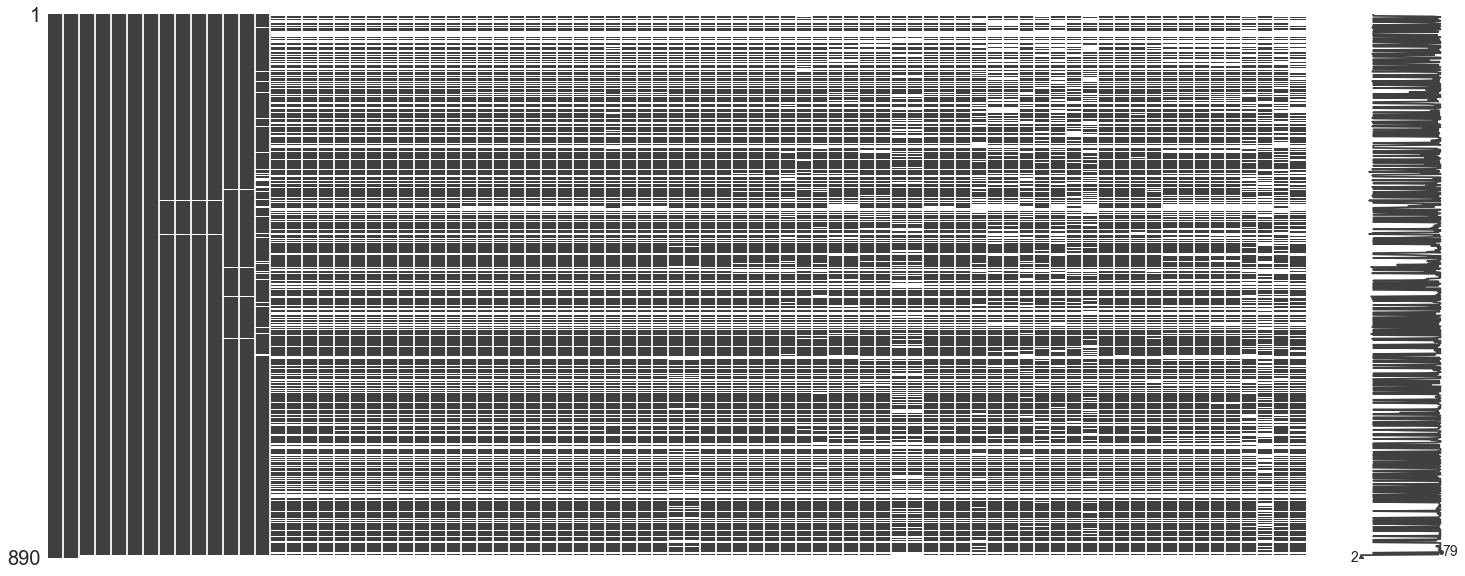

In [19]:
msno.matrix(test_df)

**The pattern is very different from the training set.** The training data set has consistently alternated rows with good and poor quality, while **on test set the distribution of the gaps is more like white noise.**

**At the same time, some of the columns have consistently high data quality on all rows.** These are the following 14 features:

In [20]:
pd.DataFrame(test_df[test_df.columns[0:14].values].isna().mean(), columns = ['missing_frac'])

missing_frac
galactic year                                           0.000000
galaxy                                                  0.000000
existence expectancy index                              0.005618
existence expectancy at birth                           0.005618
Gross income per capita                                 0.005618
Income Index                                            0.005618
Expected years of education (galactic years)            0.005618
Mean years of education (galactic years)                0.008989
Intergalactic Development Index (IDI)                   0.008989
Education Index                                         0.008989
Intergalactic Development Index (IDI), Rank             0.011236
Population using at least basic drinking-water ...      0.011236
Population using at least basic sanitation serv...      0.011236
Gross capital formation (% of GGP)                      0.069663

**Conclusions:**

1. Use IterativeImputer to fill the gaps in data
2. Predictions = Model1+Model2+Model3

## 1.4 Index(y) dynamics for all galaxies

In [21]:
fig = px.line(train_df, 
              x="galactic year", 
              y="y", 
              color='galaxy')
fig.show()

**In general index is rather stable, however starting from 1.01M galactic year there is a significant increase for a number of galaxies.**

## 1.5 All galaxies timeline (train/test)

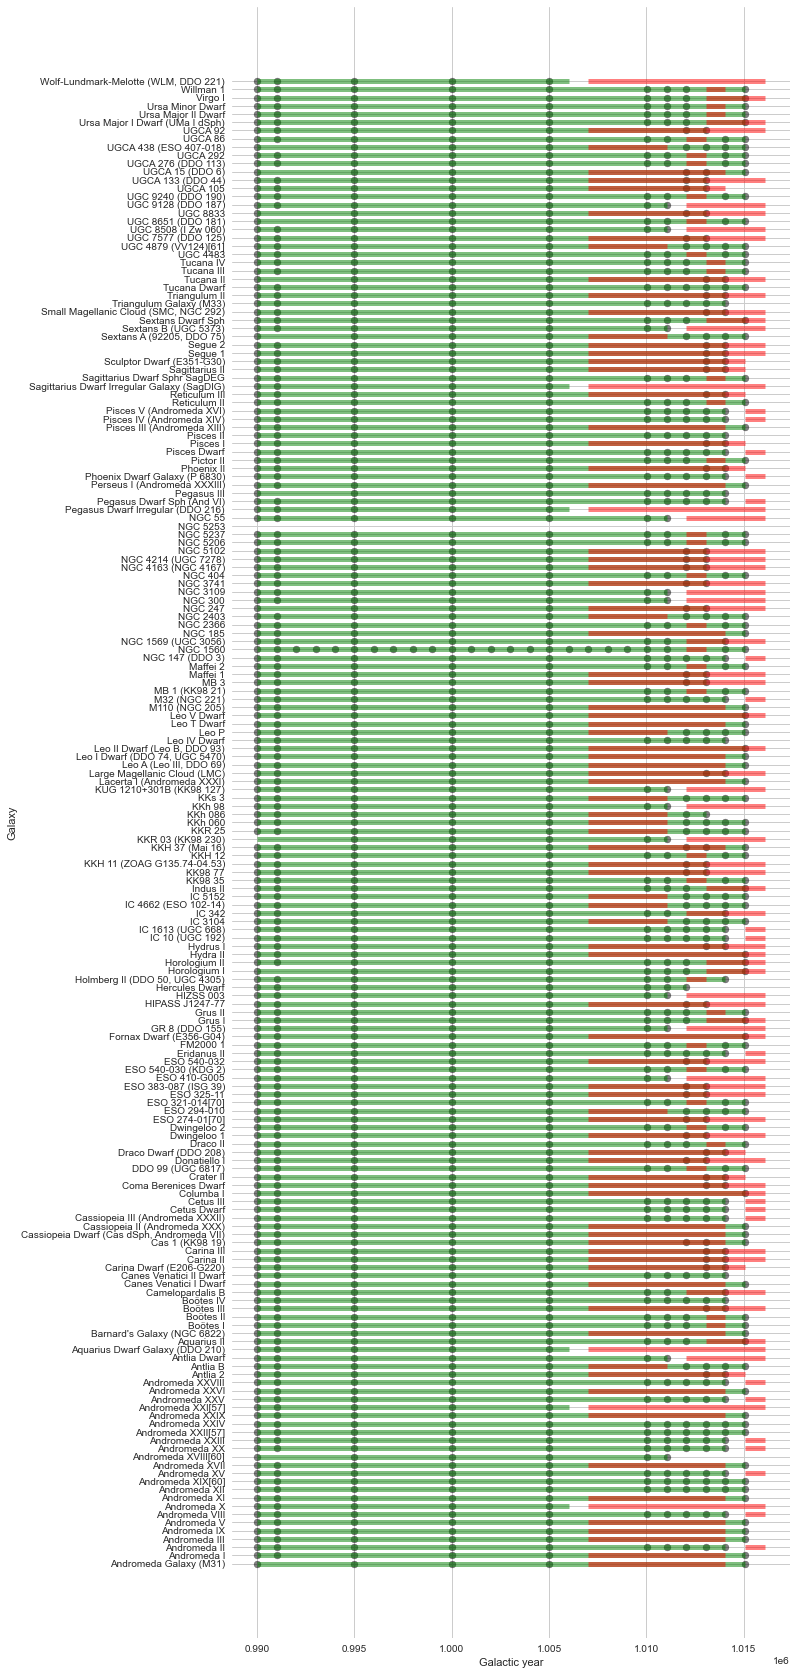

In [22]:
plot_timeline(train_df,test_df)

Comments on graph:
- green - available galactic years in train
- red - galactic years for prediction in test
- black points - galactic years with pct of missing values < 80%

## 1.6 Galaxy clustering by std(index) vs mean(index)

In [23]:
def plotter_by_years(year):
    #fig,ax = plt.subplots(figsize = (15,10))
    #ax.clear()
    plt.clf()
    plt.xlim([0,0.1])
    plt.ylim([0,0.4])
    #years = np.unique(train_df['galactic year'])
    #year = years[year]
    
    df = train_df[train_df['galactic year']<=year]
    k = -0.15/0.02
    stats_by_galaxy = df.groupby('galaxy').agg({'y':['std','mean']})
    buf = {ii:i for i,ii in enumerate(stats_by_galaxy.index)}
    #print(buf)
    stats_by_galaxy[('manual_border','inc')] = 1*((0.15+stats_by_galaxy[('y','std')]*k)<=(stats_by_galaxy[ ('y','mean')]))
    stats_by_galaxy['galactic year'] = year
    p = sns.scatterplot(x = ('y','std'),
                        y = ('y','mean'),
                        data = stats_by_galaxy,
                        hue=('manual_border','inc'),
                        legend='full')
    #print(stats_by_galaxy)
    for i,line in stats_by_galaxy.iterrows():
        # if ~np.isfinite(line[('y','std')])  and ~np.isfinite(line[('y','mean')]):
        if line[('y','std')] < 1000 and line[('y','mean')] < 1000:
            #print(buf[i])
            #print(line[('y','std')], line[('y','mean')],)
            p.text(line[('y','std')], line[('y','mean')], 
            buf[i], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
    #print(buf[i])
    
    t = np.arange(0,0.02,0.001)
    p.set_title(df['galactic year'].max())
    
    
    #print(f"higher than line {sum(stats_by_galaxy[('manual_border','inc')])}, other side {sum(1-stats_by_galaxy[('manual_border','inc')])}")
    plt.plot(t,k*t+0.15)
    return stats_by_galaxy

In [24]:
import matplotlib.animation as animation
import numpy as np
from pylab import *
from IPython.display import HTML

dpi = 100

def ani_by_years():
    fig,ax = plt.subplots(figsize = (15,10))

    years = np.unique(train_df['galactic year'])
    ani = animation.FuncAnimation(fig,plotter_by_years, years)
    writer = animation.writers['ffmpeg'](fps=1)

    #ani.save('demo2.mp4',writer=writer,dpi=dpi)
    return ani
#HTML(ani.to_html5_video())

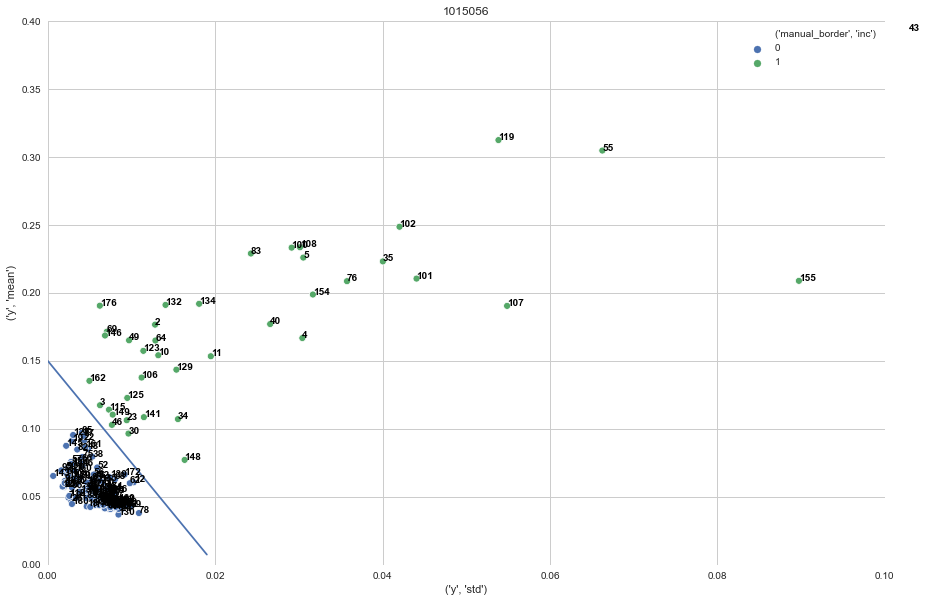

In [25]:
HTML(ani_by_years().to_html5_video())

y_std    y_mean  manual_border_inc  \
galaxy                                                                        
Andromeda Galaxy (M31)                     NaN  0.049214                  0   
Andromeda I                                NaN  0.053204                  0   
Andromeda II                               NaN  0.167935                  0   
Andromeda III                              NaN  0.110758                  0   
Andromeda IX                               NaN  0.151314                  0   
...                                        ...       ...                ...   
Ursa Major II Dwarf                   0.006213  0.190628                  1   
Ursa Minor Dwarf                      0.006881  0.051538                  0   
Virgo I                               0.007463  0.042337                  0   
Willman 1                             0.006156  0.055283                  0   
Wolf-Lundmark-Melotte (WLM, DDO 221)  0.002882  0.044738                  0   

                                      galactic year_  
galaxy                                                
Andromeda Galaxy (M31)                        990025  
Andromeda I                                   990025  
Andromeda II                                  990025  
Andromeda III                                 990025  
Andromeda IX                                  990025  
...                                              ...  
Ursa Major II Dwarf                          1015056  
Ursa Minor Dwarf                             1015056  
Virgo I                                      1015056  
Willman 1                                    1015056  
Wolf-Lundmark-Melotte (WLM, DDO 221)         1015056  

[4706 rows x 4 columns]

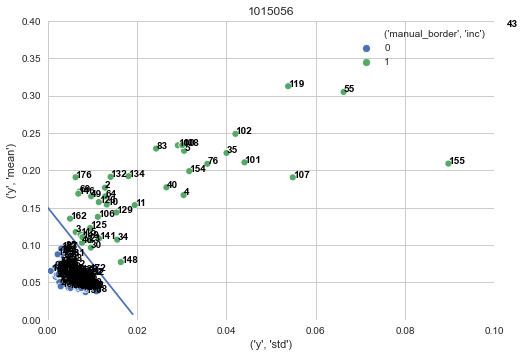

In [26]:
years = np.unique(train_df['galactic year'])
galaxy_stable_cl_arr = []
for y in years:
    galaxy_stable_cl_arr.append(plotter_by_years(y))
    
galaxy_stable_cl_df =  pd.concat(galaxy_stable_cl_arr, axis = 0)
#galaxy_stable_cl_df.columns = galaxy_stable_cl_df.columns.droplevel()
galaxy_stable_cl_df.columns = ['_'.join(col) for col in galaxy_stable_cl_df.columns]
galaxy_stable_cl_df

In [27]:
train_df_with_stable_marker = \
    pd.merge(train_df, 
             galaxy_stable_cl_df[['galactic year_', 'manual_border_inc']], 
             how = 'left',
             left_on = ['galactic year', 'galaxy'],
             right_on = ['galactic year_', 'galaxy']
        )
train_df_with_stable_marker

galactic year                        galaxy  existence expectancy index  \
0            990025  Large Magellanic Cloud (LMC)                    0.628657   
1            990025              Camelopardalis B                    0.818082   
2            990025                       Virgo I                    0.659443   
3            990025            UGC 8651 (DDO 181)                    0.555862   
4            990025                  Tucana Dwarf                    0.991196   
...             ...                           ...                         ...   
3860        1015056                     Columba I                    1.029704   
3861        1015056  Leo II Dwarf (Leo B, DDO 93)                    0.937869   
3862        1015056        Canes Venatici I Dwarf                    1.036144   
3863        1015056                         KKs 3                    0.939034   
3864        1015056                      NGC 5237                    1.032244   

      existence expectancy at birth  Gross income per capita  Income Index  \
0                         63.125200             27109.234310      0.646039   
1                         81.004994             30166.793958      0.852246   
2                         59.570534              8441.707353      0.499762   
3                         52.333293                      NaN           NaN   
4                         81.802464             81033.956906      1.131163   
...                             ...                      ...           ...   
3860                      82.832063             34310.471408      0.855094   
3861                      75.877098             36899.067719      0.929494   
3862                      93.540275             37002.977875      1.085245   
3863                      78.274427             28180.459770      0.687655   
3864                      91.641356             73109.215949      1.207746   

      Expected years of education (galactic years)  \
0                                         8.240543   
1                                        10.671823   
2                                         8.840316   
3                                              NaN   
4                                        13.800672   
...                                            ...   
3860                                     18.578586   
3861                                     16.153857   
3862                                     21.066473   
3863                                      9.388911   
3864                                     18.910920   

      Mean years of education (galactic years)  \
0                                          NaN   
1                                     4.742470   
2                                     5.583973   
3                                          NaN   
4                                    13.188907   
...                                        ...   
3860                                 10.557143   
3861                                  9.151665   
3862                                 16.661344   
3863                                  8.908748   
3864                                 16.202486   

      Intergalactic Development Index (IDI)  Education Index  ...  \
0                                       NaN              NaN  ...   
1                                  0.833624         0.467873  ...   
2                                  0.469110         0.363837  ...   
3                                       NaN              NaN  ...   
4                                  0.910341         0.918353  ...   
...                                     ...              ...  ...   
3860                               0.906573         0.862826  ...   
3861                               0.865822         0.747577  ...   
3862                               0.983835         1.100779  ...   
3863                               0.735694         0.602703  ...   
3864                               1.171634         1.085080  ...   

      Gender Deve

In [28]:
tttff = train_df_with_stable_marker.drop(columns = ['galaxy'], axis = 1).dropna()

X = tttff.iloc[:, 0:78]
y = tttff[['manual_border_inc']]


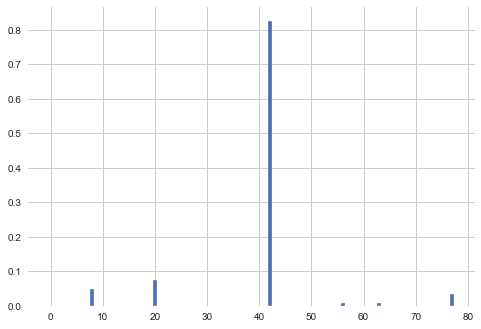

importance                                             galaxy
42    0.825742            Gross galactic product (GGP) per capita
20   0.0749527    Life expectancy at birth, male (galactic years)
8    0.0496382                                    Education Index
77    0.032856                      Gender Inequality Index (GII)
56  0.00843903    Rural population with access to electricity (%)
..         ...                                                ...
26           0      Vulnerable employment (% of total employment)
25           0     Total unemployment rate (female to male ratio)
24           0  Adolescent birth rate (births per 1,000 female...
23           0  Young age (0-14) dependency ratio (per 100 cre...
39           0   Mortality rate, male grown up (per 1,000 people)

[78 rows x 2 columns]

In [29]:
# decision tree for feature importance on a classification problem
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# summarize feature importance
pd.DataFrame(np.vstack((importance, X.columns.T)).T, 
             columns = ['importance', 'galaxy']).sort_values(by = 'importance', ascending = False)

In [30]:
fig = px.scatter(train_df_with_stable_marker, 
                 x="Gross galactic product (GGP) per capita", 
                 y="y", color="manual_border_inc",)
fig.show()

In [31]:
#galaxies that have never been unstable
stable_galaxies = (pd.get_dummies(train_df_with_stable_marker, 
               columns = ['manual_border_inc']) \
    .groupby('galaxy') \
    .agg({'manual_border_inc_0':['sum'],
          'manual_border_inc_1':['sum']})['manual_border_inc_1'] == 0)\
    .query("sum == True").index.values

#galaxies that have become unstable at least once
unstable_galaxies = (pd.get_dummies(train_df_with_stable_marker, 
               columns = ['manual_border_inc']) \
    .groupby('galaxy') \
    .agg({'manual_border_inc_0':['sum'],
          'manual_border_inc_1':['sum']})['manual_border_inc_1'] > 0)\
    .query("sum == True").index.values

In [32]:
fig = px.line(train_df.query("galaxy in @stable_galaxies"), 
              x="galactic year", 
              y="y", 
              color='galaxy')
fig.show()

In [33]:
fig = px.line(train_df.query("galaxy in @unstable_galaxies"), 
              x="galactic year", 
              y="y", 
              color='galaxy')
fig.show()

## Fitting

# 2. Data preprocessing

Let's combine train and test dataset to run all the data munging and feature engineering on both of them.

In [34]:
na = train_df.shape[0]
nb = test_df.shape[0]
y_Train = train_df['y']

#Combine train and test sets
combined_df = pd.concat([train_df, 
                         test_df], sort=False).reset_index(drop=True)
#Drop the target 
combined_df.drop(['y'], axis=1, inplace=True)
print("Total size is :",combined_df.shape)

Total size is : (4755, 79)


In [35]:
cat_features=combined_df.select_dtypes(include='object')
num_features=combined_df.select_dtypes(exclude='object')
print('We have :',cat_features.shape[1],'categorical features')
print('We have :',num_features.shape[1],'numerical features')

We have : 1 categorical features
We have : 78 numerical features


In [36]:
cat_features

galaxy
0     Large Magellanic Cloud (LMC)
1                 Camelopardalis B
2                          Virgo I
3               UGC 8651 (DDO 181)
4                     Tucana Dwarf
...                            ...
4750          ESO 383-087 (ISG 39)
4751                       NGC 247
4752                    ESO 325-11
4753                   ESO 540-032
4754                       KK98 77

[4755 rows x 1 columns]

In [37]:
cat_features=combined_df.select_dtypes(include='object')
num_features=combined_df.select_dtypes(exclude='object')
print('We have :',cat_features.shape[1],'categorical features')
print('We have :',num_features.shape[1],'numerical features')

We have : 1 categorical features
We have : 78 numerical features


## 2.1 OHE  for galaxy feature:

In [38]:
combined_df_ohe = pd.get_dummies(combined_df, columns = ['galaxy'])
combined_df_ohe

galactic year  existence expectancy index  \
0            990025                    0.628657   
1            990025                    0.818082   
2            990025                    0.659443   
3            990025                    0.555862   
4            990025                    0.991196   
...             ...                         ...   
4750        1016064                         NaN   
4751        1016064                         NaN   
4752        1016064                         NaN   
4753        1016064                         NaN   
4754        1016064                         NaN   

      existence expectancy at birth  Gross income per capita  Income Index  \
0                         63.125200             27109.234310      0.646039   
1                         81.004994             30166.793958      0.852246   
2                         59.570534              8441.707353      0.499762   
3                         52.333293                      NaN           NaN   
4                         81.802464             81033.956906      1.131163   
...                             ...                      ...           ...   
4750                            NaN                      NaN           NaN   
4751                            NaN                      NaN           NaN   
4752                            NaN                      NaN           NaN   
4753                            NaN                      NaN           NaN   
4754                            NaN                      NaN           NaN   

      Expected years of education (galactic years)  \
0                                         8.240543   
1                                        10.671823   
2                                         8.840316   
3                                              NaN   
4                                        13.800672   
...                                            ...   
4750                                           NaN   
4751                                           NaN   
4752                                           NaN   
4753                                           NaN   
4754                                           NaN   

      Mean years of education (galactic years)  \
0                                          NaN   
1                                     4.742470   
2                                     5.583973   
3                                          NaN   
4                                    13.188907   
...                                        ...   
4750                                       NaN   
4751                                       NaN   
4752                                       NaN   
4753                                       NaN   
4754                                       NaN   

      Intergalactic Development Index (IDI)  Education Index  \
0                                       NaN              NaN   
1                                  0.833624         0.467873   
2                                  0.469110         0.363837   
3                                       NaN              NaN   
4                                  0.910341         0.918353   
...                                     ...              ...   
4750                                    NaN              NaN   
4751                                    NaN              NaN   
4752                                    NaN              NaN   
4753                                    NaN              NaN   
4754                                    NaN              NaN   

      Intergalactic Development Index (IDI), Rank  ...  galaxy_UGCA 292  \
0                                             NaN  ...                0   
1                                      152.522198  ...                0   
2                                      209.813266  ...                0   
3                                             NaN  ...                0   
4                                       71.885345  ...        

In [39]:
Main_df_ohe = combined_df_ohe[:na]  #na is the number of rows of the original training set
Main_df_ohe['y'] = y_Train
Submission_df_ohe = combined_df_ohe[na:] 

/Users/paul/opt/anaconda3/envs/python36env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 2.2 Label encoding for galaxy feature:

In [40]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

combined_df_le = combined_df.copy()
combined_df_le['galaxy'] = le.fit_transform(combined_df['galaxy'])

#combined_df_ohe= pd.get_dummies(combined_df, columns = ['galaxy'])
#combined_df_ohe

## Interpolation missing values

In [41]:
#combined_df_le['gal_year'] = combined_df_le['galactic year'].apply(lambda y: int(str(y)[0:-3]))
#combined_df_le['gal_month'] = combined_df_le['galactic year'].apply(lambda y: int(str(y)[-3:]))


In [42]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
combined_df_le_imp = pd.DataFrame(imputer.fit_transform(combined_df_le), 
                                  columns = combined_df_le.columns,
                                  index = combined_df_le.index)

In [43]:
from datetime import date
Main_df_le = combined_df_le[:na]  #na is the number of rows of the original training set
Main_df_le['y'] = y_Train
Submission_df_le = combined_df_le[na:] 

from datetime import date
Main_df_le_imp = combined_df_le_imp[:na]  #na is the number of rows of the original training set
Main_df_le_imp['y'] = y_Train
Submission_df_le_imp = combined_df_le_imp[na:] 


/Users/paul/opt/anaconda3/envs/python36env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/paul/opt/anaconda3/envs/python36env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
le.inverse_transform([84])

array(['KK98 77'], dtype=object)

# 3. Train/test split

## 5.1 Train/test split with OHE

Let's build a basic constant model to test the adequacy of models. We will try to predict last index with previous one. For each galaxy we will take 80% of data for train dataset and 20% for test. It would be ~ 15 train points and 5 test points.

In [45]:
train_arr = [] 
test_arr = []
for gal in Main_df_ohe.columns[78:-1]:
    gal_df = Main_df_ohe[Main_df_ohe[gal] == 1].sort_values(by = 'galactic year')
    train_gal_df = gal_df.head(round(len(gal_df)*0.8))
    test_gal_df = gal_df.tail(len(gal_df) - round(len(gal_df)*0.8))
    
    #test_gal_df['y_pred_last'] = train_gal_df.iloc[-1].y
    
    train_arr.append(train_gal_df)
    test_arr.append(test_gal_df)
    #test_arr.append(test_gal_df[['galaxy','y', 'y_pred_last']])
    
ml_train_df_ohe = pd.concat(train_arr, axis=0)
ml_test_df_ohe = pd.concat(test_arr, axis=0)

**Resulting train df for machine learning (chronological split 80/20 for each galaxy) with OHE:**

In [46]:
ml_train_df_ohe

galactic year  existence expectancy index  \
125          990025                    0.759989   
242          991020                    0.769566   
465          992016                    0.791677   
673          993012                    0.822373   
731          994009                    0.838323   
...             ...                         ...   
1722         999000                    0.660889   
1877        1000000                    0.612819   
1986        1001000                    0.563886   
2300        1002001                    0.572757   
2391        1003002                    0.628426   

      existence expectancy at birth  Gross income per capita  Income Index  \
125                       72.020628             18445.323465      0.647025   
242                       68.279470             17844.399709      0.678283   
465                       69.154885             17407.794954      0.658309   
673                       74.018880             27287.948235      0.829902   
731                       71.627275             18470.436157      0.578029   
...                             ...                      ...           ...   
1722                      56.066073             19187.054755      0.585624   
1877                      56.669453             16952.419780      0.422337   
1986                      55.468746              9186.085615      0.601818   
2300                      59.739468             25898.581693      0.537441   
2391                      58.772174             26523.825270      0.572390   

      Expected years of education (galactic years)  \
125                                      13.819287   
242                                      15.518075   
465                                      14.660651   
673                                      15.874337   
731                                      14.421358   
...                                            ...   
1722                                      8.615109   
1877                                      7.821792   
1986                                      9.485736   
2300                                      7.874701   
2391                                      9.186143   

      Mean years of education (galactic years)  \
125                                        NaN   
242                                        NaN   
465                                        NaN   
673                                        NaN   
731                                        NaN   
...                                        ...   
1722                                  4.785679   
1877                                  4.924727   
1986                                  5.276078   
2300                                  5.668153   
2391                                  3.807712   

      Intergalactic Development Index (IDI)  Education Index  \
125                                     NaN              NaN   
242                                     NaN              NaN   
465                                     NaN              NaN   
673                                     NaN              NaN   
731                                     NaN              NaN   
...                                     ...              ...   
1722                               0.530653         0.320388   
1877                               0.533550         0.345571   
1986                               0.493454         0.295607   
2300                               0.475786         0.401828   
2391                               0.525476         0.366503   

      Intergalactic Development Index (IDI), Rank  ...  \
125                                           NaN  ...   
242                                           NaN  ...   
465                                           NaN  ...   
673                                           NaN  ...   
731                                           NaN  ...   
...                                           ...  ...   
1722                           

**Resulting test df for machine learning (chronological split 80/20 for each galaxy) with OHE:**

In [47]:
ml_test_df_ohe

galactic year  existence expectancy index  \
2606        1004004                    0.803915   
2798        1005006                    0.860011   
2949        1006009                    0.810644   
3820        1015056                    0.837170   
2656        1004004                    0.749034   
...             ...                         ...   
3575        1012036                    1.019051   
3800        1015056                    1.010563   
2687        1004004                    0.603825   
2813        1005006                    0.574464   
3015        1006009                    0.614594   

      existence expectancy at birth  Gross income per capita  Income Index  \
2606                      82.718434             17299.571482      0.691448   
2798                      73.682279             24971.716308      0.669550   
2949                      68.456526             15943.829766      0.766118   
3820                      68.742404             20952.636648      0.757196   
2656                      72.093220             30068.140432      0.641228   
...                             ...                      ...           ...   
3575                      88.858002             57791.697346      1.120865   
3800                      92.515213             61890.593811      1.219435   
2687                      58.301528             10659.494788      0.629569   
2813                      53.416728             23157.558055      0.627428   
3015                      58.751698             24016.067851      0.623884   

      Expected years of education (galactic years)  \
2606                                     16.083635   
2798                                     12.858577   
2949                                     14.236676   
3820                                     14.281498   
2656                                     12.510524   
...                                            ...   
3575                                     16.485195   
3800                                     18.016207   
2687                                      7.827124   
2813                                      9.626455   
3015                                     10.522855   

      Mean years of education (galactic years)  \
2606                                 11.282011   
2798                                 10.493260   
2949                                  9.962169   
3820                                 10.329880   
2656                                  7.132999   
...                                        ...   
3575                                 12.873299   
3800                                 13.395910   
2687                                  4.244244   
2813                                  6.992821   
3015                                  5.472547   

      Intergalactic Development Index (IDI)  Education Index  \
2606                               0.715746         0.745786   
2798                               0.727915         0.806982   
2949                               0.757072         0.852921   
3820                               0.759207         0.801123   
2656                               0.673619         0.528564   
...                                     ...              ...   
3575                               1.010275         0.917192   
3800                               1.020538         0.871133   
2687                               0.615265         0.402917   
2813                               0.464677         0.402599   
3015                               0.547071         0.501966   

      Intergalactic Development Index (IDI), Rank  ...  \
2606                                   191.852274  ...   
2798                                   172.983630  ...   
2949                                   180.488519  ...   
3820                                   186.040542  ...   
2656                                   155.296208  ...   
...                                           ...  ...   
3575                           

In [48]:
print('The shape of our training set with OHE: ',
      ml_train_df_ohe.shape[0], 'rows', 'and', 
      ml_train_df_ohe.shape[1], 'features')
print('The shape of our testing set with OHE: ',
      ml_test_df_ohe.shape[0], 'tows', 'and', 
      ml_test_df_ohe.shape[1], 'features')

The shape of our training set with OHE:  3075 rows and 260 features
The shape of our testing set with OHE:  790 tows and 260 features


## 5.2 Train/test split with label encoding

In [49]:
train_arr = [] 
test_arr = []
for gal in Main_df_le.galaxy.unique():
    gal_df = Main_df_le[Main_df_le.galaxy == gal].sort_values(by = 'galactic year')
    train_gal_df = gal_df.head(round(len(gal_df)*0.8))
    test_gal_df = gal_df.tail(len(gal_df) - round(len(gal_df)*0.8))
    
    train_arr.append(train_gal_df)
    test_arr.append(test_gal_df)


ml_train_df_le = pd.concat(train_arr, axis=0)
ml_test_df_le = pd.concat(test_arr, axis=0)

**Resulting train df for machine learning (chronological split 80/20 for each galaxy) with Label Encoder:**

In [50]:
ml_train_df_le

galactic year  galaxy  existence expectancy index  \
0            990025      96                    0.628657   
194          991020      96                    0.627245   
410          992016      96                    0.662135   
543          993012      96                    0.687776   
765          994009      96                    0.727717   
...             ...     ...                         ...   
1935        1000000     123                    1.050665   
2141        1001000     123                    0.844850   
2201        1002001     123                    1.030589   
2360        1003002     123                    1.082063   
2563        1004004     123                    1.091676   

      existence expectancy at birth  Gross income per capita  Income Index  \
0                         63.125200             27109.234310      0.646039   
194                       62.389059             17114.109182      0.503198   
410                       68.794245             13225.033915      0.692653   
543                       62.848660              9116.133706      0.667264   
765                       67.482431              3598.172394      0.609830   
...                             ...                      ...           ...   
1935                      93.724445             59652.081278      1.034496   
2141                      88.435371             45563.801554      1.104573   
2201                      88.525573             58796.622838      0.989668   
2360                      87.188294             63414.021330      1.024548   
2563                      86.984952             66671.711229      1.069811   

      Expected years of education (galactic years)  \
0                                         8.240543   
194                                       9.317262   
410                                       8.030645   
543                                      11.347429   
765                                      10.402265   
...                                            ...   
1935                                     19.450685   
2141                                     19.641817   
2201                                     19.912055   
2360                                     17.438581   
2563                                     19.201916   

      Mean years of education (galactic years)  \
0                                          NaN   
194                                        NaN   
410                                        NaN   
543                                        NaN   
765                                        NaN   
...                                        ...   
1935                                 15.039388   
2141                                 15.495203   
2201                                 14.563946   
2360                                 14.292940   
2563                                 13.947544   

      Intergalactic Development Index (IDI)  Education Index  ...  \
0                                       NaN              NaN  ...   
194                                     NaN              NaN  ...   
410                                     NaN              NaN  ...   
543                                     NaN              NaN  ...   
765                                     NaN              NaN  ...   
...                                     ...              ...  ...   
1935                               1.074652         1.027331  ...   
2141                               1.078410         1.000917  ...   
2201                               1.024476         1.037976  ...   
2360                               1.076053         0.996646  ...   
2563                               1.113395         1.057824  ...   

      Intergalactic Development Index (IDI), female  \
0                                               NaN   
194                                             NaN   
410                                             NaN   
543                                             NaN   
765   

**Resulting test df for machine learning (chronological split 80/20 for each galaxy) with Label Encoder:**

In [51]:
ml_test_df_le

galactic year  galaxy  existence expectancy index  \
2846        1005006      96                    0.883358   
2891        1006009      96                    0.881534   
3679        1013042      96                    0.814879   
3770        1014049      96                    0.874476   
3202        1008016      33                    1.025858   
...             ...     ...                         ...   
3851        1015056     124                    0.761416   
2848        1005006     123                    1.080452   
3040        1006009     123                    1.143596   
3512        1012036     123                    1.083807   
3610        1013042     123                    1.074489   

      existence expectancy at birth  Gross income per capita  Income Index  \
2846                      81.251875             21785.494822      0.767434   
2891                      70.398402             17220.027191      0.823692   
3679                      83.287364             16453.884262      0.899114   
3770                      73.896443             24825.701169      0.848819   
3202                      84.713881             36756.122206      0.979876   
...                             ...                      ...           ...   
3851                      69.917068             25382.182629      0.864719   
2848                      92.192055             52238.818082      0.981938   
3040                      89.762503             46090.953928      1.103940   
3512                      87.420338             61057.801088      1.110189   
3610                      91.615981             59098.449903      1.096430   

      Expected years of education (galactic years)  \
2846                                     14.378038   
2891                                     12.883945   
3679                                     14.376047   
3770                                     13.816971   
3202                                     14.799702   
...                                            ...   
3851                                     14.677399   
2848                                     19.461596   
3040                                     21.213489   
3512                                     16.698035   
3610                                     20.861973   

      Mean years of education (galactic years)  \
2846                                  5.248527   
2891                                  4.533346   
3679                                  6.873462   
3770                                  6.697298   
3202                                  9.769916   
...                                        ...   
3851                                  8.713354   
2848                                 15.568753   
3040                                 16.022024   
3512                                 15.320563   
3610                                 14.997213   

      Intergalactic Development Index (IDI)  Education Index  ...  \
2846                               0.576582         0.526375  ...   
2891                               0.753770         0.549646  ...   
3679                               0.769918         0.538083  ...   
3770                               0.871930         0.620290  ...   
3202                               0.785850         0.741084  ...   
...                                     ...              ...  ...   
3851                               0.780627         0.786752  ...   
2848                               0.956783         1.012429  ...   
3040                               1.128388         0.945926  ...   
3512                               1.019514         1.223794  ...   
3610                               1.009153         1.040462  ...   

      Intergalactic Development Index (IDI), female  \
2846                                       0.634861   
2891                                            NaN   
3679                                       0.752930   
3770                                       0.773306   
3202  

In [52]:
print('The shape of our training set with Lebel Encoder: ',
      ml_train_df_le.shape[0], 'rows', 'and', 
      ml_train_df_le.shape[1], 'features')
print('The shape of our testing set with Lebel Encoder: ',
      ml_test_df_le.shape[0], 'tows', 'and', 
      ml_test_df_le.shape[1], 'features')

The shape of our training set with Lebel Encoder:  3075 rows and 80 features
The shape of our testing set with Lebel Encoder:  790 tows and 80 features


# 4. True Train/Test split + stratification by years

In [53]:
#Main_df_le 
#Main_df_le['y']
#Submission_df_le

In [54]:
from utils import plot_timeline_true, true_train_test_split
X_train_true, y_train_true, \
X_valid_true, y_valid_true, \
X_test_true, y_test_true = true_train_test_split(Main_df_le_imp, Submission_df_le_imp) #WITH KNN IMP

train_df_true = X_train_true.join(y_train_true) 
valid_df_true = X_valid_true.join(y_valid_true) 
test_df_true = X_test_true.join(y_test_true) 

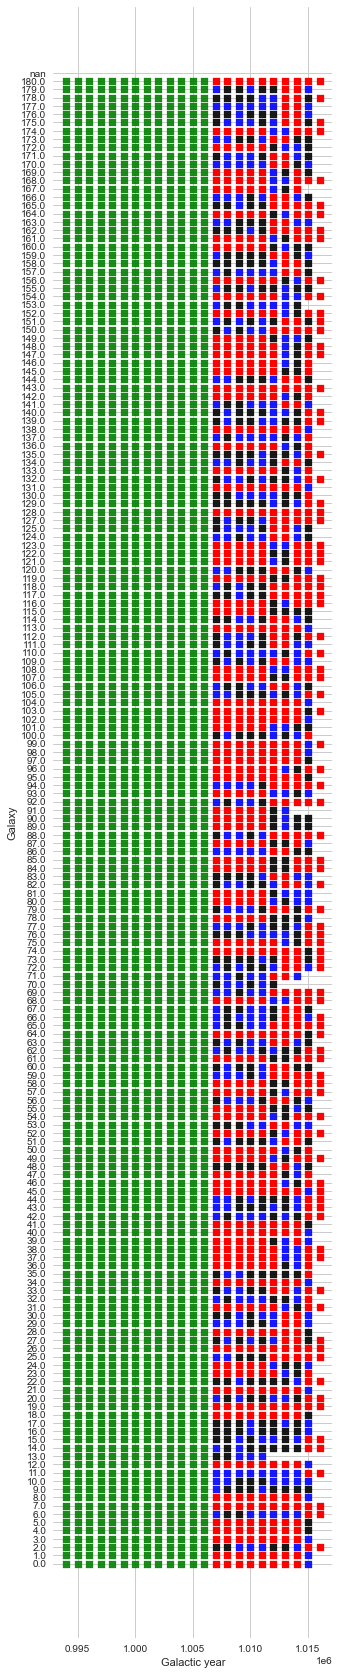

In [55]:
plot_timeline_true(X_train_true, X_valid_true, X_test_true, Submission_df_le)

## Make valid great again

In [56]:
X_train_true_t = pd.DataFrame() # train train
X_train_true_v = pd.DataFrame() # train valid
y_train_true_t = pd.DataFrame() # 
y_train_true_v = pd.DataFrame()  # 

for gal in X_train_true.galaxy.unique():
    cur_gal_xtrain_t = X_train_true.query("galaxy == @gal").sort_values(by = 'galactic year').iloc[0:-4, :]
    cur_gal_xtrain_v = X_train_true.query("galaxy == @gal").sort_values(by = 'galactic year').iloc[-4:, :]
    
    X_train_true_t = pd.concat([X_train_true_t, cur_gal_xtrain_t])
    X_train_true_v = pd.concat([X_train_true_v, cur_gal_xtrain_v])
    y_train_true_t = pd.concat([y_train_true_t, y_train_true.loc[cur_gal_xtrain_t.index]])
    y_train_true_v = pd.concat([y_train_true_v, y_train_true.loc[cur_gal_xtrain_v.index]])
    
    
train_df_true_t = X_train_true_t.join(y_train_true_t) #train
train_df_true_v = X_train_true_v.join(y_train_true_v) #valid
test_df_true_с = pd.concat([valid_df_true,test_df_true]) #combined


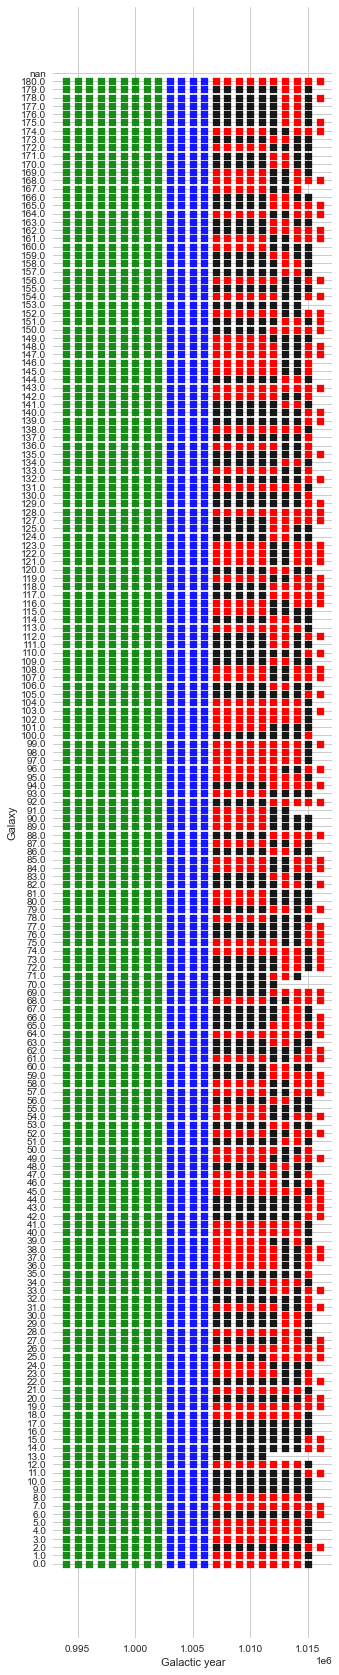

In [57]:
plot_timeline_true(train_df_true_t, train_df_true_v, test_df_true_с, Submission_df_le)

# 4. Baseline models

In [58]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV


import math

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

## 4.1 Constant baseline model (last index propagation)

In [59]:
pd.options.mode.chained_assignment = None  # default='warn
#Using 
#ml_train_df_ohe
#ml_test_df_ohe


from sklearn.metrics import mean_squared_error as mse
def constant_baseline_scoring(train_df, test_df):
    y_true = []
    y_pred = []

    galaxies = pd.concat([train_df, test_df])['galaxy'].unique()
    for gal in galaxies:
        gal_df_train = train_df[train_df['galaxy'] == gal].sort_values(by = 'galactic year')
        gal_df_test = test_df[test_df['galaxy'] == gal]
        gal_df_test['y_pred_last'] = gal_df_train.iloc[-1].y

        y_true.extend(gal_df_test.y.values)
        y_pred.extend(gal_df_test.y_pred_last.values)

    return mse(y_true, y_pred)**0.5

def evaluate_constant_model(train_df_true, test_df_true):
    print('Constant model (last index) for STABLE galaxies: RMSE TEST =  {:.4f}' \
        .format(constant_baseline_scoring(
                    train_df_true[train_df_true.galaxy.isin(le.transform(stable_galaxies))], 
                    test_df_true[test_df_true.galaxy.isin(le.transform(stable_galaxies))]
                )
               )
         )

    print('Constant model (last index) for UNSTABLE galaxies: RMSE TEST =  {:.4f}' \
        .format(constant_baseline_scoring(
                    train_df_true[train_df_true.galaxy.isin(le.transform(unstable_galaxies))], 
                    test_df_true[test_df_true.galaxy.isin(le.transform(unstable_galaxies))]
                )
               )
         )

    print('Constant model (last index) for ALL galaxies: RMSE TEST =  {:.4f}' \
        .format(constant_baseline_scoring(
                    train_df_true, 
                    test_df_true
                )
               )
         )

In [60]:
evaluate_constant_model(pd.concat([train_df_true_v,train_df_true_t]), test_df_true_с)

Constant model (last index) for STABLE galaxies: RMSE TEST =  0.0105
Constant model (last index) for UNSTABLE galaxies: RMSE TEST =  0.0662
Constant model (last index) for ALL galaxies: RMSE TEST =  0.0330


## 4.2 Baseline model 2 (random forest with NA = -999)

Fill all NA with constant -999:

In [61]:
#Using 
#ml_train_df_le
#ml_test_df_le

X_train_rf = pd.concat([train_df_true_v,train_df_true_t]).fillna(-999).drop(['y'], axis=1)
y_train_rf = pd.concat([train_df_true_v,train_df_true_t]).y

X_test_rf = test_df_true_с.fillna(-999).drop(['y'], axis=1)
y_test_rf = test_df_true_с.y

In [62]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [4,5,6,7,8,9,10]#[int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



param_grid = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8]
}

print('Parameter grid:')
print(random_grid)

Parameter grid:
{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [63]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

#rfr=RandomForestRegressor(random_state=2718)
#rf_random = RandomizedSearchCV(estimator = rfr, 
#                               param_distributions = random_grid, 
#                               scoring='neg_mean_absolute_error',
#                               n_iter = 50, 
#                               cv = 5, 
#                               verbose=1, 
#                               random_state=2718,
#                               n_jobs = -1)

#rf_random.fit(X_train_rf, y_train_rf)

#print("Best estimator: ",rf_random.best_estimator_)
#print("Best CV5 RMSE: ",(-rf_random.best_score_))

In [64]:
rfr_best=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=2718, verbose=0, warm_start=False)
rfr_best.fit(X_train_rf, y_train_rf)

rfr_best_train=rfr_best.predict(X_train_rf)
rfr_best_test=rfr_best.predict(X_test_rf)

print('Random forest with best params RMSE train+valid/test : {:.4f}/{:.4f}' \
      .format(mse(y_train_rf, rfr_best_train)**0.5, 
              mse(y_test_rf, rfr_best_test)**0.5))


Random forest with best params RMSE train+valid/test : 0.0030/0.0496


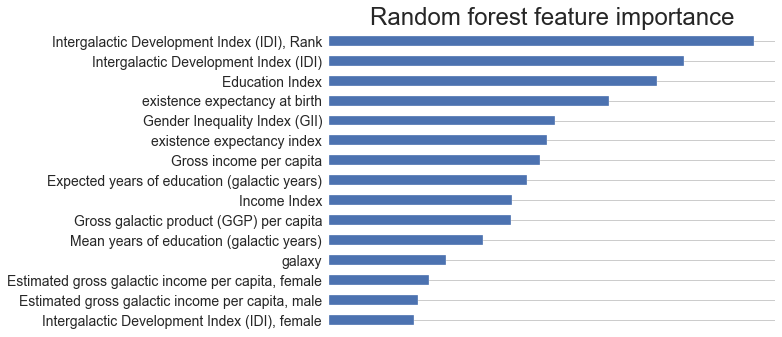

In [65]:
# Create a dataframe of the variable importances
rfr_best_fimp = pd.DataFrame(X_train_rf.columns, columns = ['feature'])
rfr_best_fimp['fscore'] = rfr_best.feature_importances_[:, ]

def plot_fimp(rfr_best_fimp, plt_title):
    # Plot the relative importance of the top 10 features
    rfr_best_fimp['fscore'] = rfr_best_fimp['fscore'] / rfr_best_fimp['fscore'].max()
    rfr_best_fimp.sort_values('fscore', ascending = False, inplace = True)
    rfr_best_fimp = rfr_best_fimp[0:15]
    rfr_best_fimp.sort_values('fscore', ascending = True, inplace = True)
    rfr_best_fimp.plot(kind='barh', x='feature', y='fscore', legend=False)
    plt.title(plt_title, fontsize = 24)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([], [])
    plt.yticks(fontsize=14)
    plt.show()
    #plt.gcf().savefig('feature_importance_xgb.png')

plot_fimp(rfr_best_fimp, 'Random forest feature importance')

# 3. Data cleaning

## 3.1 Filling gaps with mean

In [66]:
def fill_mean_by_galaxy(df):
    from sklearn.impute import SimpleImputer
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', verbose = 1)

    for gal in df.galaxy.unique():
        data = df.query("galaxy == @gal")

        #filling mean from full dataframe for features without observed values
        data_isnull_mean_agg = data.isnull().mean()
        for col in data_isnull_mean_agg[data_isnull_mean_agg == 1].index:
            data[col] = df[col].mean()


        data_imp = pd.DataFrame(imp_mean.fit_transform(data), columns = data.columns, index = data.index)

        df.update(data_imp)

In [67]:
def bfill_by_galaxy(df):
    #from sklearn.impute import SimpleImputer
    #imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', verbose = 1)

    for gal in df.galaxy.unique():
        data = df.query("galaxy == @gal")

        #filling mean from full dataframe for features without observed values
        #data_isnull_mean_agg = data.isnull().mean()
        #for col in data_isnull_mean_agg[data_isnull_mean_agg == 1].index:
        #    data[col] = df[col].mean()

        
        #data_imp = pd.DataFrame(imp_mean.fit_transform(data), columns = data.columns, index = data.index)

        df.update(data.fillna(method = 'bfill'))

https://medium.com/@krrai77/using-fancyimpute-in-python-eadcffece782

https://github.com/iskandr/fancyimpute

https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation

Let's apply IterativeImputer: A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion:

In [68]:
# explicitly require this experimental feature
#from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
#from sklearn.impute import IterativeImputer

#imp_mean = IterativeImputer(random_state=2718, verbose = 1)
#combined_df_ohe_imp = pd.DataFrame(imp_mean.fit_transform(combined_df_ohe), columns = combined_df_ohe.columns)


In [69]:
#combined_df_ohe_imp

## 3.2 Transforming skewed distributions

* **log transform skewed numeric features:**

In [70]:
# explicitly require this experimental feature
#from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
#from sklearn.impute import IterativeImputer

#imp_mean = IterativeImputer(random_state=2718, verbose = 1)
#combined_df_ohe_imp = pd.DataFrame(imp_mean.fit_transform(combined_df_ohe), columns = combined_df_ohe.columns)


In [71]:
#num_features.columns.values

#from scipy.stats import skewtest

#combined_df_ohe_imp['Remittances, inflows (% of GGP)'].hist().plot()
#np.log1p(combined_df_ohe_imp['Remittances, inflows (% of GGP)']).hist().plot()
#skewtest(combined_df_ohe_imp['Remittances, inflows (% of GGP)'])

In [72]:
#from scipy.stats import skew


#skewed_feats = combined_df_ohe_imp[num_features.columns.values].apply(lambda x: skew(x.dropna())) #compute skewness
#skewed_feats = skewed_feats[skewed_feats > 0.75]
#skewed_feats = skewed_feats.index

#combined_df_ohe_imp[skewed_feats] = np.log1p(combined_df_ohe_imp[skewed_feats])

In [73]:
#skewed_feats.sort_values(ascending = True)[:10]

# 4. Feature engineering

## 4.1 Constant extrapolation

In [74]:
from tqdm import tqdm
tqdm.pandas()

def fe_last_known_index(df, full_timeline_df, step = 1, feature = 'y'):
    def find_last_knowh_index(df, galaxy, year, step):
        last_known_index = float('nan')
        cur_gal = df \
            .query("galaxy == @galaxy and `galactic year` < @year and " + feature + "!='NaN'") \
            .sort_values(by = 'galactic year')
        if len(cur_gal) > step-1: last_known_index = cur_gal.tail(step)[feature].values[0]
        return last_known_index

    df[feature + '_previous' + str(step)] = df \
        .progress_apply(lambda row: find_last_knowh_index(full_timeline_df, 
                                             row['galaxy'], 
                                             row['galactic year'],
                                             step), axis = 1)

In [75]:
def fe_mean_known_index(df, full_timeline_df, step = 5, feature = 'y'):
    def find_mean_known_index(df, galaxy, year, step):
        last_known_index = float('nan')
        cur_gal = df \
            .query("galaxy == @galaxy and `galactic year` <= @year and " + feature + "!='NaN'") \
            .sort_values(by = 'galactic year')
        if len(cur_gal) > 0: last_known_index = cur_gal.tail(step)[feature].mean()
        return last_known_index

    df[feature + '_previous' + str(step) + '_mean'] = df \
        .progress_apply(lambda row: find_mean_known_index(full_timeline_df, 
                                             row['galaxy'], 
                                             row['galactic year'],
                                             step), axis = 1)

## 4.2 Exponential extrapolation

In [76]:
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt
from utils import lmfit_predict


[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 25
    # variables        = 4
    chi-square         = 0.05501496
    reduced chi-square = 0.00261976
    Akaike info crit   = -144.975648
    Bayesian info crit = -140.100145
##  Warning: uncertainties could not be estimated:
    d:  at initial value
[[Variables]]
    a:  0.10215192 (init = 0)
    b: -0.50596773 (init = 0)
    c:  0.24561617 (init = 0)
    d:  2.00000000 (init = 2)


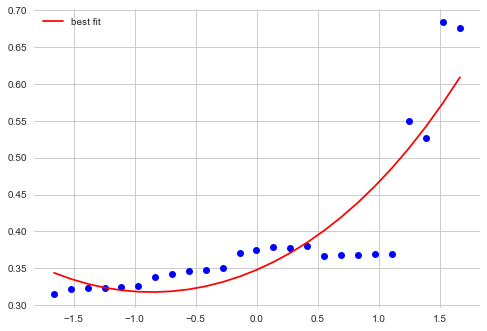

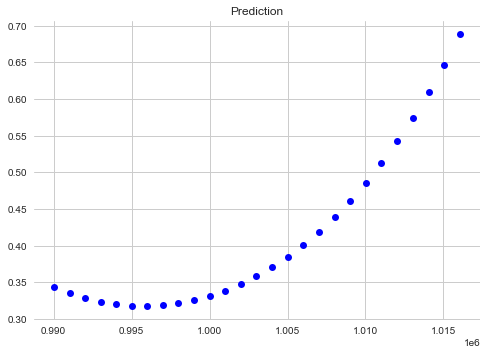

(0.05501496103526009,
     galactic year  y_pred_exp
 25        1015056    0.647125
 26        1016064    0.688169)

In [77]:
lmfit_predict(train_df, test_df, 
              'Cetus Dwarf', 
              d_fix = 0.5, 
              verbose = 1)

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1097
    # data points      = 18
    # variables        = 4
    chi-square         = 7.9492e-05
    reduced chi-square = 5.6780e-06
    Akaike info crit   = -213.944121
    Bayesian info crit = -210.382634
##  Warning: uncertainties could not be estimated:
    d:  at initial value
[[Variables]]
    a:  223.630458 (init = 0)
    b:  0.09995384 (init = 0)
    c: -223.586059 (init = 0)
    d:  2.00000000 (init = 2)


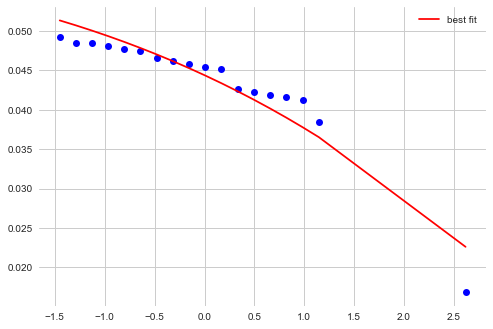

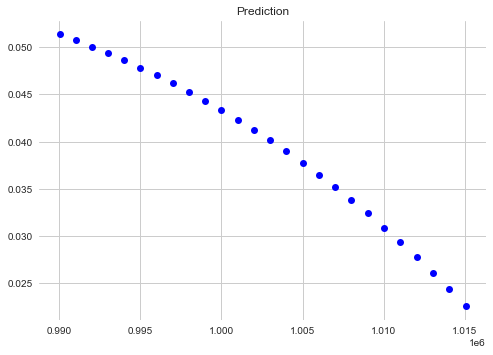

(7.949176154010238e-05,
     galactic year  y_pred_exp
 17        1007012    0.035203
 18        1008016    0.033831
 19        1009020    0.032404
 20        1010025    0.030920
 21        1011030    0.029378
 22        1012036    0.027775
 23        1013042    0.026111
 24        1014049    0.024383)

In [78]:
lmfit_predict(train_df, test_df, 
              'Andromeda Galaxy (M31)', 
              d_fix = 0.1,  verbose = 1)

In [79]:
from utils import evaluate_and_fit_lgbm, evaluate_and_fit_cb
def evaluate_regressors(train_df_true, valid_df_true, test_df_true, comment):
    #if regressor_type == 'lgbm':
        #print('-----------------------------------')
        #print('LightGBM for STABLE galaxies', comment)

        #evaluate_and_fit_lgbm(
        #    train_df_true[train_df_true.galaxy.isin(le.transform(stable_galaxies))], 
        #    valid_df_true[valid_df_true.galaxy.isin(le.transform(stable_galaxies))], 
        #    test_df_true[test_df_true.galaxy.isin(le.transform(stable_galaxies))]
        #)
        #print()
        #print('-----------------------------------')
        #print('LightGBM for UNSTABLE galaxies', comment)
        #evaluate_and_fit_lgbm(
        #    train_df_true[train_df_true.galaxy.isin(le.transform(unstable_galaxies))],
        #    valid_df_true[valid_df_true.galaxy.isin(le.transform(unstable_galaxies))], 
        #    test_df_true[test_df_true.galaxy.isin(le.transform(unstable_galaxies))]
        #)
    print()
    print('-----------------------------------')
    print('LightGBM for ALL galaxies', comment)
    
    params_dict_lgb = {
        'objective': ['regression',],
        'learning_rate':[0.01,0.1],
        'max_bin':[128,255,512],  
    }
    print('Params dict:', params_dict_lgb)
    evaluate_and_fit_lgbm(params_dict_lgb,
        train_df_true, 
        valid_df_true,
        test_df_true
    )
    #elif regressor_type == 'cb':
        #print('-----------------------------------')
        #print('CatBoost for STABLE galaxies', comment)

        #evaluate_and_fit_cb(
        #    train_df_true[train_df_true.galaxy.isin(le.transform(stable_galaxies))], 
        #    valid_df_true[valid_df_true.galaxy.isin(le.transform(stable_galaxies))], 
        #    test_df_true[test_df_true.galaxy.isin(le.transform(stable_galaxies))]
        #)
        #print()
        #print('-----------------------------------')
        #print('CatBoost for UNSTABLE galaxies', comment)
        #evaluate_and_fit_cb(
        #    train_df_true[train_df_true.galaxy.isin(le.transform(unstable_galaxies))],
        #    valid_df_true[valid_df_true.galaxy.isin(le.transform(unstable_galaxies))], 
        #    test_df_true[test_df_true.galaxy.isin(le.transform(unstable_galaxies))]
        #)
    if True:
        print()
        print('-----------------------------------')
        print('CatBoost for ALL galaxies', comment)

        params_dict_cb = {
            'num_boost_round': [1000],
            'early_stopping_rounds': [100],
            'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
            'l2_leaf_reg':[3,1,5,10,100],
            'depth': [4, 7, 10]}
        print('Params dict:', params_dict_cb)
        evaluate_and_fit_cb(params_dict_cb,
            train_df_true, 
            valid_df_true,
            test_df_true
        )

# Light GBM

In [82]:
#evaluate_regressors(train_df_true, valid_df_true, test_df_true, 'without extra-features')
evaluate_regressors(train_df_true_t, train_df_true_v, test_df_true_с, 'without extra-features')


  0%|          | 0/6 [00:00<?, ?it/s]


-----------------------------------
LightGBM for ALL galaxies without extra-features
Params dict: {'objective': ['regression'], 'learning_rate': [0.01, 0.1], 'max_bin': [128, 255, 512]}

Workflow: Train/valid/test...


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


Best LGMB params {'objective': 'regression', 'learning_rate': 0.1, 'max_bin': 128}
LGBM best model RMSE VALID/TEST:0.0005/0.0494

Workflow: Train+valid/test...


  0%|          | 0/90 [00:00<?, ?it/s]

LGBM with best params RMSE TRAIN\TEST :0.0026/0.0420

-----------------------------------
CatBoost for ALL galaxies without extra-features
Params dict: {'num_boost_round': [1000], 'early_stopping_rounds': [100], 'learning_rate': [0.03, 0.001, 0.01, 0.1, 0.2, 0.3], 'l2_leaf_reg': [3, 1, 5, 10, 100], 'depth': [4, 7, 10]}

Workflow: Train/valid/test...


  6%|▌         | 5/90 [01:23<18:57, 13.38s/it]

KeyboardInterrupt: 

### train best lgbm

In [80]:
#best params
params_dict_lgb = {
        'objective': ['regression',],
        'learning_rate':[0.1],
        'max_bin':[128],  
    }
print('Params dict:', params_dict_lgb)
best_gbm_with_0xfe, _ = evaluate_and_fit_lgbm(params_dict_lgb,
    train_df_true_t, train_df_true_v, test_df_true_с
)

  0%|          | 0/1 [00:00<?, ?it/s]

Params dict: {'objective': ['regression'], 'learning_rate': [0.1], 'max_bin': [128]}

Workflow: Train/valid/test...


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Best LGMB params {'objective': 'regression', 'learning_rate': 0.1, 'max_bin': 128}
LGBM best model RMSE VALID/TEST:0.0005/0.0502

Workflow: Train+valid/test...
LGBM with best params RMSE TRAIN\TEST :0.0003/0.0418


#### train best catboost

In [81]:
params_dict_cb = {'num_boost_round': [1000], 
                  'early_stopping_rounds': [100], 
                  'learning_rate': [0.1], 
                  'l2_leaf_reg': [5], 
                  'depth': [4]}
print('Params dict:', params_dict_cb)
best_catboost_with_0xfe, _ = evaluate_and_fit_cb(params_dict_cb,
    train_df_true_t, train_df_true_v, test_df_true_с
)

  0%|          | 0/1 [00:00<?, ?it/s]

Params dict: {'num_boost_round': [1000], 'early_stopping_rounds': [100], 'learning_rate': [0.1], 'l2_leaf_reg': [5], 'depth': [4]}

Workflow: Train/valid/test...


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Best CatBoost params {'num_boost_round': 1000, 'early_stopping_rounds': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'depth': 4}
CatBoost best model RMSE VALID/TEST:0.0227/0.0497

Workflow: Train+valid/test...
CatBoost with best params RMSE TRAIN\TEST :0.0044/0.0422


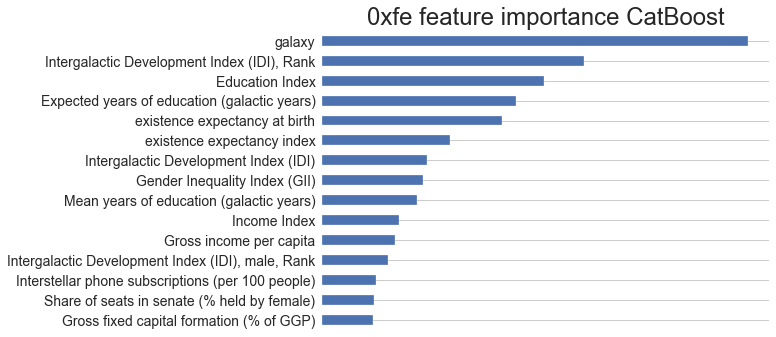

In [82]:
# Create a dataframe of the variable importances
import catboost as cb
from catboost import Pool

cb_0xfe_fimp = pd.DataFrame(test_df_true_с.drop('y', axis = 1).columns, columns = ['feature'])
cb_0xfe_fimp['fscore'] = best_catboost_with_0xfe \
    .get_feature_importance(Pool(test_df_true_с.drop('y', axis = 1),  test_df_true_с.y))
plot_fimp(cb_0xfe_fimp, '0xfe feature importance CatBoost')

In [84]:
cb_predict = pd.DataFrame(best_catboost_with_0xfe.predict(Submission_df_le), 
                          columns = ['y_pred_catboost'],
                          index = Submission_df_le.index)
cb_predict.to_parquet('predictions/cb_predict')

cb_predict_full = pd.DataFrame(best_catboost_with_0xfe.predict(pd.concat([Main_df_le, Submission_df_le])), 
                          columns = ['y_pred_catboost'],
                          index = pd.concat([Main_df_le, Submission_df_le]).index)
cb_predict_full.to_parquet('predictions/cb_predict_full')

In [94]:
params_dict_cb = {'num_boost_round': [1000], 
                  'early_stopping_rounds': [100], 
                  'learning_rate': [0.1], 
                  'l2_leaf_reg': [5], 
                  'depth': [4]}
print('Params dict:', params_dict_cb)
best_catboost_with_0xfe, _ = evaluate_and_fit_cb(params_dict_cb,
    train_df_true_t,  test_df_true_с, train_df_true_v
)

  0%|          | 0/1 [00:00<?, ?it/s]

Params dict: {'num_boost_round': [1000], 'early_stopping_rounds': [100], 'learning_rate': [0.1], 'l2_leaf_reg': [5], 'depth': [4]}

Workflow: Train/valid/test...


100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


Best CatBoost params {'num_boost_round': 1000, 'early_stopping_rounds': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'depth': 4}
CatBoost best model RMSE VALID/TEST:0.0457/0.0200

Workflow: Train+valid/test...
CatBoost with best params RMSE TRAIN\TEST :0.0063/0.0170


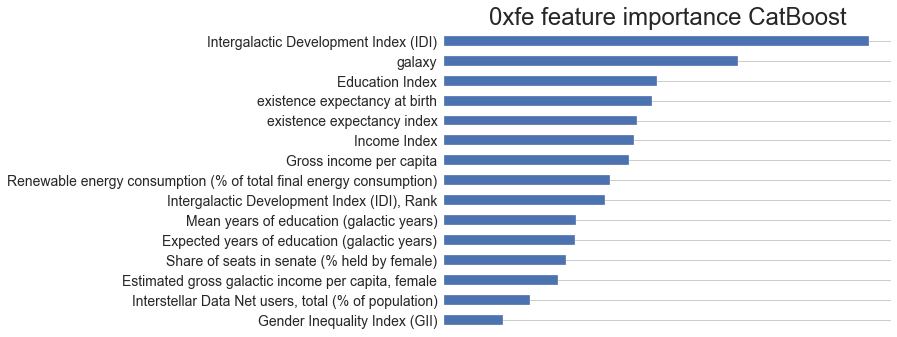

In [95]:
# Create a dataframe of the variable importances
import catboost as cb
from catboost import Pool

cb_0xfe_fimp = pd.DataFrame(test_df_true_с.drop('y', axis = 1).columns, columns = ['feature'])
cb_0xfe_fimp['fscore'] = best_catboost_with_0xfe \
    .get_feature_importance(Pool(test_df_true_с.drop('y', axis = 1),  test_df_true_с.y))
plot_fimp(cb_0xfe_fimp, '0xfe feature importance CatBoost')

In [86]:
cb_predict = pd.DataFrame(best_catboost_with_0xfe.predict(Submission_df_le), 
                          columns = ['y_pred_catboost'],
                          index = Submission_df_le.index)
cb_predict.to_parquet('predictions/cb_predict_v2')

cb_predict_full = pd.DataFrame(best_catboost_with_0xfe.predict(pd.concat([Main_df_le, Submission_df_le])), 
                          columns = ['y_pred_catboost'],
                          index = pd.concat([Main_df_le, Submission_df_le]).index)
cb_predict_full.to_parquet('predictions/cb_predict_full_v2')

In [102]:
test_df_true_с.to_parquet('predictions/test_df_true_c')

In [188]:
Main_df_le.columns

Index(['galactic year', 'galaxy', 'existence expectancy index',
       'existence expectancy at birth', 'Gross income per capita',
       'Income Index', 'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank',
       'Population using at least basic drinking-water services (%)',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)', 'Population, total (millions)',
       'Population, urban (%)',
       'Mortality rate, under-five (per 1,000 live births)',
       'Mortality rate, infant (per 1,000 live births)',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Population, ages 15–64 (millions)',
       'Population, ages 65 and older (millions)',
       'Life expectancy at birth, male (galactic years)',
       'Life expect

In [202]:
Main_df_le.query("galaxy == 100")[['galactic year','galaxy', 'Intergalactic Development Index (IDI), Rank', 'Gender Development Index (GDI)']]

galactic year  galaxy  Intergalactic Development Index (IDI), Rank  \
94           990025     100                                    63.411166   
227          991020     100                                    52.946206   
507          992016     100                                    63.103398   
644          993012     100                                    74.709302   
788          994009     100                                    40.992630   
1078         995006     100                                    58.456974   
1254         996004     100                                    96.930531   
1414         997002     100                                    76.194169   
1557         998001     100                                    66.770932   
1772         999000     100                                    67.021671   
1830        1000000     100                                    65.831726   
2038        1001000     100                                    54.572137   
2191        1002001     100                                    70.532599   
2374        1003002     100                                    72.955833   
2524        1004004     100                                    72.917280   
2711        1005006     100                                    32.769027   
2937        1006009     100                                    62.642710   
3118        1007012     100                                    36.755163   
3214        1008016     100                                    70.459073   
3257        1009020     100                                    79.749258   
3351        1010025     100                                    80.939963   
3510        1011030     100                                    42.139278   
3566        1012036     100                                    40.587565   
3623        1013042     100                                    28.452556   
3753        1014049     100                                    64.909703   

      Gender Development Index (GDI)  
94                               NaN  
227                              NaN  
507                              NaN  
644                              NaN  
788                              NaN  
1078                        1.073512  
1254                             NaN  
1414                             NaN  
1557                             NaN  
1772                             NaN  
1830                        1.038825  
2038                             NaN  
2191                             NaN  
2374                             NaN  
2524                             NaN  
2711                        1.039587  
2937                             NaN  
3118                             NaN  
3214                             NaN  
3257                             NaN  
3351                        1.049449  
3510                        1.064704  
3566                        1.103028  
3623                        1.066421  
3753                        1.041810

## Potential EDA

In [119]:
test_df_true_с_peda = test_df_true_с.copy()
test_df_true_с_peda['y_pred'] = best_gbm_with_0xfe.predict(test_df_true_с.drop('y', axis = 1))
test_df_true_с_peda['p2_pred'] = (-np.log(test_df_true_с_peda['y_pred']+0.01)+3)**2
test_df_true_с_peda['p2'] = (-np.log(test_df_true_с_peda['y']+0.01)+3)**2



Text(0, 0.5, 'p2_pred')

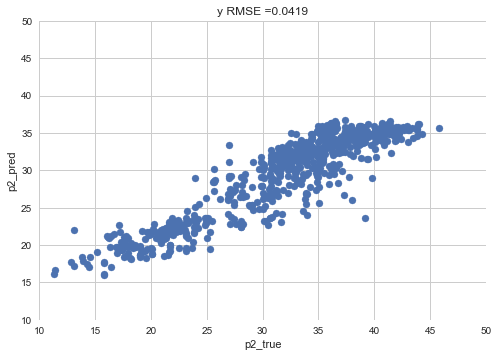

In [120]:
plt.figure()
plt.scatter(test_df_true_с_peda['p2'], test_df_true_с_peda['p2_pred'])
plt.title('y RMSE ={:.4f}'.format(mse(test_df_true_с_peda.y, test_df_true_с_peda.y_pred)**0.5))
plt.xlabel('p2_true')
plt.xlim((10,50))
plt.ylim((10,50))
plt.ylabel('p2_pred')

In [121]:
import plotly.express as px

#df = px.data.tips()
fig = px.scatter(test_df_true_с_peda, x="p2_pred", y="p2", trendline="ols")
fig.show()

# Light GBM + y_previous

In [77]:
#inplace for train from df: train
fe_last_known_index(train_df_true_t, 
                    train_df_true_t,
                    step =1)
#inplace for valid from df: train+valid(y empty)
fe_last_known_index(train_df_true_v, 
                    pd.concat([train_df_true_t,train_df_true_v.drop(['y'], axis = 1)]),
                    step =1)
#inplace for test from df: train+valid +test(y_empty)
fe_last_known_index(test_df_true_с, 
                    pd.concat([train_df_true_t, train_df_true_v, test_df_true_с.drop(['y'], axis = 1)]),
                    step =1)

100%|██████████| 804/804 [00:06<00:00, 130.15it/s]


In [78]:
evaluate_regressors(train_df_true_t, train_df_true_v, test_df_true_с, 'with y_previous')

  0%|          | 0/6 [00:00<?, ?it/s]


-----------------------------------
LightGBM for ALL galaxies with y_previous
Params dict: {'objective': ['regression'], 'learning_rate': [0.01, 0.1], 'max_bin': [128, 255, 512]}

Workflow: Train/valid/test...


100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


Best LGMB params {'objective': 'regression', 'learning_rate': 0.1, 'max_bin': 128}
LGBM best model RMSE VALID/TEST:0.0000/0.0346

Workflow: Train+valid/test...
LGBM with best params RMSE TRAIN\TEST :0.0008/0.0326


# Light GBM iterational

In [79]:
#best params
params_dict_lgb = {
        'objective': ['regression',],
        'learning_rate':[0.1],
        'max_bin':[128],  
    }
print('Params dict:', params_dict_lgb)
best_gbm_with_1xfe, _ = evaluate_and_fit_lgbm(params_dict_lgb,
    train_df_true_t, train_df_true_v, test_df_true_с
)

  0%|          | 0/1 [00:00<?, ?it/s]

Params dict: {'objective': ['regression'], 'learning_rate': [0.1], 'max_bin': [128]}

Workflow: Train/valid/test...


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Best LGMB params {'objective': 'regression', 'learning_rate': 0.1, 'max_bin': 128}
LGBM best model RMSE VALID/TEST:0.0000/0.0346

Workflow: Train+valid/test...
LGBM with best params RMSE TRAIN\TEST :0.0008/0.0326


## Create baseline mean prediction feature

In [80]:
def fe_exp_predict(df_input, df_for_prediction,d_fix, feature = 'y' ):
    def exp_linear_predict(df_input, df_for_prediction, galaxy, year):
        #print(galaxy, year)
        try:
            _, pred_df = lmfit_predict(df_input, df_for_prediction, 
                  galaxy, 
                  d_fix = 0,  verbose = 0)

            cur_gal_year_pred = pred_df.query("`galactic year` == @year").drop_duplicates().head(1)['y_pred_exp'].values[0]
        except:
            cur_gal_year_pred = float('nan')
        return cur_gal_year_pred

    df_input[feature + '_previous_pred'] = df_input \
        .progress_apply(lambda row: exp_linear_predict(df_input, 
                                                          df_for_prediction,
                                             row['galaxy'], 
                                             row['galactic year']
                                                         ), axis = 1)

In [81]:
#inplace for train from df: train
fe_exp_predict(train_df_true_t, 
                    train_df_true_t, d_fix = 0)
#inplace for valid from df: train+valid(y empty)
fe_exp_predict(train_df_true_v, 
                    pd.concat([train_df_true_t,train_df_true_v.drop(['y'], axis = 1)],)
                    , d_fix = 0)
#inplace for test from df: train+valid +test(y_empty)
fe_exp_predict(test_df_true_с, 
                    pd.concat([train_df_true_t, train_df_true_v, test_df_true_с.drop(['y'], axis = 1)]),
                    d_fix = 0)

100%|██████████| 804/804 [00:28<00:00, 27.90it/s]


In [82]:
train_df_true_v.query('galaxy == 111').iloc[:, -4:]

Gender Inequality Index (GII)         y  y_previous1  y_previous_pred
2386                            NaN  0.052577     0.052728         0.052980
2684                            NaN  0.052571     0.052728         0.052355
2760                       0.658017  0.052507     0.052728         0.051730
2983                            NaN  0.050515     0.052728         0.051105

In [83]:
test_df_true_с.query('galaxy == 111').iloc[:, -4:]

Gender Inequality Index (GII)         y  y_previous1  y_previous_pred
3850                       0.697308  0.033304     0.050515         0.034185
3693                       0.641243  0.036274     0.050515         0.036586
3283                            NaN  0.050569     0.050515         0.048576
3175                            NaN  0.050491     0.050515         0.050971
3413                       0.656306  0.050656     0.050515         0.046180
3106                            NaN  0.050493     0.050515         0.053365
3485                       0.563881  0.041859     0.050515         0.043784

## Fit best model from validation

In [84]:
#best params
params_dict_lgb = {
        'objective': ['regression',],
        'learning_rate':[0.1],
        'max_bin':[128],  
    }
print('Params dict:', params_dict_lgb)
best_gbm_with_2xfe, _ = evaluate_and_fit_lgbm(params_dict_lgb,
    train_df_true_t, train_df_true_v, test_df_true_с
)

  0%|          | 0/1 [00:00<?, ?it/s]

Params dict: {'objective': ['regression'], 'learning_rate': [0.1], 'max_bin': [128]}

Workflow: Train/valid/test...


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Best LGMB params {'objective': 'regression', 'learning_rate': 0.1, 'max_bin': 128}
LGBM best model RMSE VALID/TEST:0.0000/0.0477

Workflow: Train+valid/test...
LGBM with best params RMSE TRAIN\TEST :0.0000/0.0476


## 2xfe prediction

In [86]:
test_df_true_с['y_pred_2xfe'] = float('nan')

In [90]:
for gal in tqdm(test_df_true_с.galaxy.unique()):
    cur_gal_df = test_df_true_с.drop('y', axis = 1).query("galaxy == @gal").sort_values(by = 'galactic year', ascending = True)
    for r in range(len(cur_gal_df)):
        cur_row = cur_gal_df.iloc[r:r+1,:-1]

        cur_pred = best_gbm_with_2xfe.predict(cur_row)[0]
        cur_row['y_pred_2xfe'] = cur_pred

        test_df_true_с.update(cur_row)
        if r+2 <= cur_gal_df.shape[0]:
            cur_row2 = cur_gal_df.iloc[r+1:r+2,:-1]
            cur_row2['y_previous_pred'] = cur_pred
            test_df_true_с.update(cur_row2)


100%|██████████| 174/174 [00:27<00:00,  6.36it/s]


# 1xfe prediction

In [97]:
#test_df_true_с_1xfe = test_df_true_с.iloc[:,:-2].drop('y', axis = 1)
test_df_true_с['y_pred_1xfe'] = best_gbm_with_1xfe.predict()

In [99]:
print('RMSE test 1xfe / 2xfe  : {:.4f}/{:.4f}' \
      .format(mse(test_df_true_с.y, test_df_true_с.y_pred_1xfe)**0.5, 
              mse(test_df_true_с.y, test_df_true_с.y_pred_2xfe)**0.5))

RMSE test 1xfe / 2xfe  : 0.0326/0.0502


In [133]:
import lightgbm as lgb

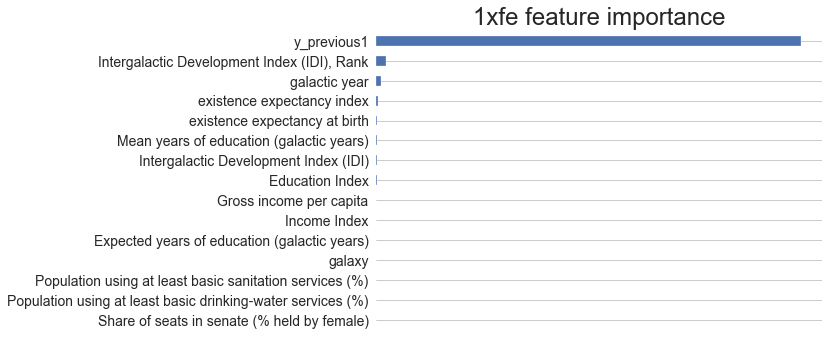

In [131]:
# Create a dataframe of the variable importances
lgb_1xfe_fimp = pd.DataFrame(test_df_true_с.iloc[:,:-3].drop('y', axis = 1).columns, columns = ['feature'])
lgb_1xfe_fimp['fscore'] = best_gbm_with_1xfe.feature_importance(importance_type='gain')
plot_fimp(lgb_1xfe_fimp, '1xfe feature importance')

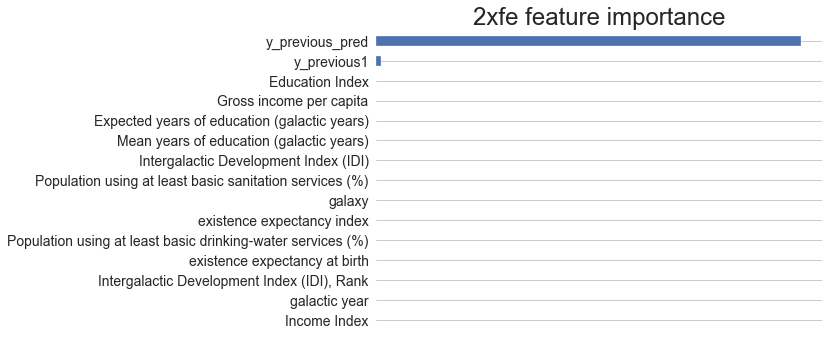

In [132]:
# Create a dataframe of the variable importances
lgb_2xfe_fimp = pd.DataFrame(test_df_true_с.iloc[:,:-2].drop('y', axis = 1).columns, columns = ['feature'])
lgb_2xfe_fimp['fscore'] = best_gbm_with_2xfe.feature_importance(importance_type='gain')
plot_fimp(lgb_2xfe_fimp, '2xfe feature importance')

# Light GBM + y_previous + exponential

!! Тут пока создание экспоненциального признака не обернуто в функцию которую удобно применять на любом датафрейме. 

In [75]:
#for d_const in [0.14]:
d_const = 0.14

#Precition for each galaxy to future up to max year from test_df_true
exp_pred_array_train = []
exp_pred_array_valid = []
exp_pred_array_test = []

for gal in tqdm(train_df_true.galaxy.unique()):
    if gal in le.transform(stable_galaxies):
        d_const = 0.1
    else:
        d_const = 0.4

    res_chisq_train, cur_gal_prediction_train = lmfit_predict(train_df_true, 
                                   train_df_true, 
                                   gal, 
                                   d_const,
                                   verbose = 0)
    res_chisq_valid, cur_gal_prediction_valid = lmfit_predict(train_df_true, 
                                   valid_df_true, 
                                   gal, 
                                   d_const,
                                   verbose = 0)
    res_chisq_test, cur_gal_prediction_test = lmfit_predict(pd.concat([train_df_true, valid_df_true]), 
                                   test_df_true, 
                                   gal, 
                                   d_const,
                                   verbose = 0)
    cur_gal_prediction_train['galaxy'] = gal
    cur_gal_prediction_valid['galaxy'] = gal
    cur_gal_prediction_test['galaxy'] = gal
    
    #cur_gal_prediction_train['fit_chisqr'] = res_chisq_train
    #cur_gal_prediction_valid['fit_chisqr'] = res_chisq_valid
    #cur_gal_prediction_test['fit_chisqr'] = res_chisq_test
    

    exp_pred_array_train.append(cur_gal_prediction_train)
    exp_pred_array_test.append(cur_gal_prediction_test)
    exp_pred_array_valid.append(cur_gal_prediction_valid)


exp_pred_df_train = pd.concat(exp_pred_array_train, axis = 0)
exp_pred_df_test = pd.concat(exp_pred_array_test, axis = 0)
exp_pred_df_valid = pd.concat(exp_pred_array_valid, axis = 0)

#train_df_true_exp = train_df_true.copy()
#train_df_true_exp['y_pred_exp'] = train_df_true_exp['y']

#valid_df_true_exp = valid_df_true.copy()
#valid_df_true_exp['y_pred_exp'] = valid_df_true_exp['y']

train_df_true_exp = train_df_true.merge(exp_pred_df_train.drop_duplicates(), 
                    left_on = ['galactic year', 'galaxy'],
                    right_on = ['galactic year', 'galaxy'],
                    how = 'left')


valid_df_true_exp = valid_df_true.merge(exp_pred_df_valid.drop_duplicates(), 
                    left_on = ['galactic year', 'galaxy'],
                    right_on = ['galactic year', 'galaxy'],
                    how = 'left')

test_df_true_exp = test_df_true.merge(exp_pred_df_test, 
                    left_on = ['galactic year', 'galaxy'],
                    right_on = ['galactic year', 'galaxy'],
                    how = 'left')

#train_df_true_exp.drop('y_previous1', axis = 1, inplace = True)
#valid_df_true_exp.drop('y_previous1', axis = 1, inplace = True)
#test_df_true_exp.drop('y_previous1', axis = 1, inplace = True)


#gbm, test_rmse = evaluate_and_fit_lgbm(
#train_df_true_exp, 
#valid_df_true_exp,
#test_df_true_exp
#)

#print('D_STEP = ', d_const, ' RMSE TEST', test_rmse)

100%|██████████| 180/180 [00:19<00:00,  9.00it/s]


In [76]:
#evaluate_regressors(train_df_true_exp, valid_df_true_exp, test_df_true_exp, 
#                    'with y_previous and exp')


-----------------------------------
LightGBM for ALL galaxies with y_previous and exp

Workflow: Train/valid/test...

100%|██████████| 6/6 [00:11<00:00,  2.00s/it]

Best LGMB params {'objective': 'regression', 'learning_rate': 0.1, 'max_bin': 128}

LGBM best model RMSE VALID/TEST:0.0008/0.0308

Workflow: Train+valid/test...

  0%|          | 0/90 [00:00<?, ?it/s]

**LGBM with best params RMSE TRAIN\TEST :0.0003/0.0216**

-----------------------------------
CatBoost for ALL galaxies with y_previous and exp

Workflow: Train/valid/test...

100%|██████████| 90/90 [33:51<00:00, 22.57s/it]  

Best CatBoost params {'num_boost_round': 1000, 'early_stopping_rounds': 100, 'learning_rate': 0.3, 'l2_leaf_reg': 5, 'depth': 4}

CatBoost best model RMSE VALID/TEST:0.0273/0.0300

Workflow: Train+valid/test...

**CatBoost with best params RMSE TRAIN\TEST :0.0003/0.0235**


# ++ Rolling

In [76]:
def fe_calculate_rolling(df, RW = 5):
    it = 0
    for gal in tqdm(df.galaxy.unique()):
        cur_gal_df = df.query("galaxy == @gal").sort_values(by = 'galactic year')
        for ii, col in enumerate(cur_gal_df.columns[2:-3]):
            cur_gal_df['fe_columns' + str(ii)] = df[col].diff().rolling(window = RW).mean()
        #print(ii, col)
        if it == 0:
            df = df.join(cur_gal_df[cur_gal_df.columns[82:]])
        else:
            df.update(cur_gal_df)
        it+=1
    return df

In [77]:
train_df_true_exp_rl = fe_calculate_rolling(train_df_true_exp)
valid_df_true_exp_rl = fe_calculate_rolling(valid_df_true_exp)
test_df_true_exp_rl = fe_calculate_rolling(test_df_true_exp)


100%|██████████| 148/148 [00:24<00:00,  6.04it/s]


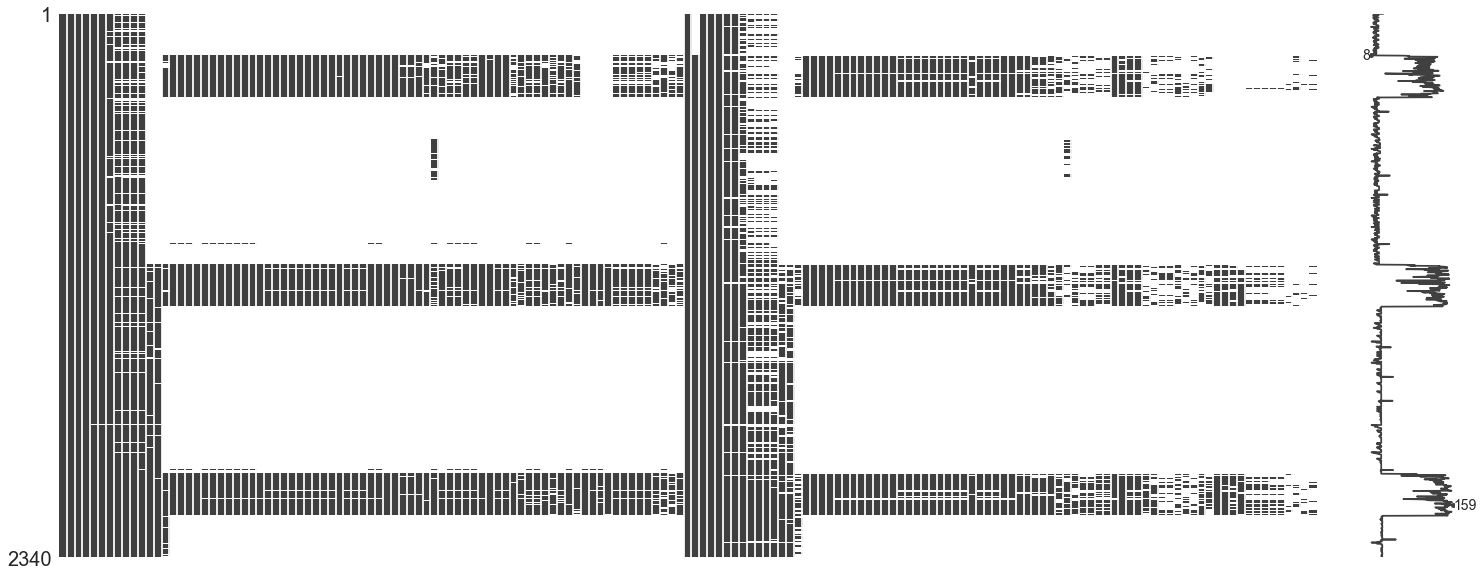

In [78]:
msno.matrix(train_df_true_exp_rl)

In [79]:
#evaluate_regressors(train_df_true_exp_rl, valid_df_true_exp_rl, test_df_true_exp_rl, 
#    'with y_previous, exp and rolling features')

# 6. Submission

## 6.1 Train best model

LGBM is better. Train lgLGBM on y_prev + exp and predict:

In [77]:
params_dict_lgb = {
        'objective': ['regression',],
        'learning_rate':[0.01,0.1],
        'max_bin':[128,255,512],  
    }
print('Params dict:', params_dict_lgb)
gbm_exp, gbm_rmse = evaluate_and_fit_lgbm(params_dict_lgb,
    train_df_true_exp, 
    valid_df_true_exp,
    test_df_true_exp
)

  0%|          | 0/6 [00:00<?, ?it/s]

Params dict: {'objective': ['regression'], 'learning_rate': [0.01, 0.1], 'max_bin': [128, 255, 512]}

Workflow: Train/valid/test...


100%|██████████| 6/6 [00:07<00:00,  1.18s/it]


Best LGMB params {'objective': 'regression', 'learning_rate': 0.1, 'max_bin': 128}
LGBM best model RMSE VALID/TEST:0.0008/0.0308

Workflow: Train+valid/test...
LGBM with best params RMSE TRAIN\TEST :0.0003/0.0216


## 6.2 Analyse predictions

In [80]:
test_df_true_exp_eda = test_df_true_exp.copy()
test_df_true_exp_eda['y_pred'] = gbm_exp.predict(test_df_true_exp_eda.drop(['y'], axis = 1))

train_df_true_exp_eda = train_df_true_exp.copy()
train_df_true_exp_eda['y_pred'] = gbm_exp.predict(train_df_true_exp_eda.drop(['y'], axis = 1))
valid_df_true_exp_eda = valid_df_true_exp.copy()
valid_df_true_exp_eda['y_pred'] = gbm_exp.predict(valid_df_true_exp_eda.drop(['y'], axis = 1))


test_df_true_exp_eda['pred_diff'] = (test_df_true_exp_eda['y_pred'] - test_df_true_exp_eda['y']) 
test_df_true_exp_eda['abs_pred_diff'] = np.abs(test_df_true_exp_eda['pred_diff']) 
test_df_true_exp_eda = test_df_true_exp_eda.reset_index()

In [ ]:
def plot_predictions_by_gal(gal):
    full_df = pd.concat([full_df_exp, Submission_df_le_exp]) \
    .query("galaxy == 5").sort_values(by = 'galactic year')

plt.scatter(full_df['galactic year'], full_df.y)
plt.scatter(full_df['galactic year'], full_df.y_pred_exp, color = 'red')


In [82]:
fig = px.scatter(
    pd.melt(test_df_true_exp_eda, id_vars=['index', 'galactic year', 'galaxy'], 
            value_vars=['y', 'y_pred']
           ), 
    x="index", 
    y="value", 
    color="variable")#,
    #size='pred_diff', hover_data=['petal_width'])
fig.show()

In [83]:
fig = px.scatter(
    test_df_true_exp_eda, 
    x="galactic year", 
    y="pred_diff")#,
   # size="pred_diff")#, hover_data=['petal_width'])
fig.show()

In [84]:
fig = px.scatter(
    test_df_true_exp_eda, 
    x="galaxy", 
    y="pred_diff")#,
   # size="pred_diff")#, hover_data=['petal_width'])
fig.show()

In [85]:
test_df_true_exp_eda.sort_values(by = 'abs_pred_diff', ascending = False).head(20)

index  galactic year  galaxy  existence expectancy index  \
322    322        1013042      43                    1.120860   
176    176        1011030      43                    1.086554   
49      49        1013042     100                    1.067487   
162    162        1012036      55                    1.030926   
30      30        1015056       4                    1.147190   
386    386        1010025      10                    1.024301   
314    314        1012036     107                    1.056675   
74      74        1015056     155                    1.081730   
159    159        1014049      76                    1.059019   
148    148        1014049     101                    1.043486   
161    161        1014049     155                    1.124729   
217    217        1015056       5                    1.111666   
315    315        1013042     107                    1.031190   
366    366        1011030      35                    1.059336   
261    261        1013042     119                    1.086862   
105    105        1010025      83                    1.054098   
111    111        1015056      55                    1.054125   
238    238        1012036     155                    1.041144   
400    400        1010025     129                    1.001081   
118    118        1015056     149                    0.964453   

     existence expectancy at birth  Gross income per capita  Income Index  \
322                      88.275231             56524.755720      1.123855   
176                      95.398828             54534.551505      1.050517   
49                       92.247628             67488.200191      1.190401   
162                      91.183749             81174.314672      1.200279   
30                       92.698990             44033.925422      1.025085   
386                      92.715838             43473.444444      1.079762   
314                      90.993185             89048.748574      1.299111   
74                       93.478667             83937.792781      1.146198   
159                      90.365197             59481.220272      1.026171   
148                      91.105042             69235.296937      1.126078   
161                      89.501884             75817.592959      1.146312   
217                      97.637902             67367.648825      1.128636   
315                      93.348433             93629.460562      1.174239   
366                      82.386387             45395.876744      1.049280   
261                      89.117163             48238.517035      1.051464   
105                      97.234594             80666.972002      1.039431   
111                      93.228445             83151.075861      1.173468   
238                      91.311695             77056.034015      1.150566   
400                      89.694197             38765.344900      0.995559   
118                      75.597922             30430.381695      0.981742   

     Expected years of education (galactic years)  \
322                                     23.208494   
176                                     21.788312   
49                                      21.667918   
162                                     21.955691   
30                                      19.263960   
386                                     20.251072   
314                                     17.977289   
74                                      17.426039   
159                                     20.869615   
148                                     21.445038   
161                                     15.674941   
217                                     19.863006   
315                                     19.492368   
366                                     19.167030   
261                                     19.036505   
105                                     19.836220   
111                                     21.530146   
238                                     18.133630   
400           

## 6.3 Checking submission files

In [86]:
sample_submit

index  pred  opt_pred
0        0  0.08       100
1        1  0.08       100
2        2  0.08       100
3        3  0.08       100
4        4  0.08       100
..     ...   ...       ...
885    885  0.08        10
886    886  0.08        10
887    887  0.08        10
888    888  0.08        10
889    889  0.08        10

[890 rows x 3 columns]

In [81]:
Submission_df_le

galactic year  galaxy  existence expectancy index  \
3865        1007012      84                    0.456086   
3866        1007012     142                    0.529835   
3867        1008016     142                    0.560976   
3868        1007012     147                    0.565910   
3869        1013042     178                    0.588274   
...             ...     ...                         ...   
4750        1016064      58                         NaN   
4751        1016064     116                         NaN   
4752        1016064      57                         NaN   
4753        1016064      61                         NaN   
4754        1016064      84                         NaN   

      existence expectancy at birth  Gross income per capita  Income Index  \
3865                      51.562543             12236.576447      0.593325   
3866                      57.228262              3431.883825      0.675407   
3867                      59.379539             27562.914252      0.594624   
3868                      59.952390             20352.232905      0.837700   
3869                      55.428320             23959.704016      0.520579   
...                             ...                      ...           ...   
4750                            NaN                      NaN           NaN   
4751                            NaN                      NaN           NaN   
4752                            NaN                      NaN           NaN   
4753                            NaN                      NaN           NaN   
4754                            NaN                      NaN           NaN   

      Expected years of education (galactic years)  \
3865                                     10.414164   
3866                                      7.239485   
3867                                     11.774890   
3868                                     11.613621   
3869                                     10.392416   
...                                            ...   
4750                                           NaN   
4751                                           NaN   
4752                                           NaN   
4753                                           NaN   
4754                                           NaN   

      Mean years of education (galactic years)  \
3865                                 10.699072   
3866                                  5.311122   
3867                                  5.937797   
3868                                 10.067882   
3869                                  6.374637   
...                                        ...   
4750                                       NaN   
4751                                       NaN   
4752                                       NaN   
4753                                       NaN   
4754                                       NaN   

      Intergalactic Development Index (IDI)  Education Index  ...  \
3865                               0.547114         0.556267  ...   
3866                               0.497688         0.409969  ...   
3867                               0.544744         0.486167  ...   
3868                               0.691641         0.523441  ...   
3869                               0.530676         0.580418  ...   
...                                     ...              ...  ...   
4750                                    NaN              NaN  ...   
4751                                    NaN              NaN  ...   
4752                                    NaN              NaN  ...   
4753                                    NaN              NaN  ...   
4754                                    NaN              NaN  ...   

      Current health expenditure (% of GGP)  \
3865                                    NaN   
3866                                    NaN   
3867                                    NaN   
3868                                    NaN   
3869                               7.357729   

In [88]:
#Using
#Main_df_le
#Submission_df_le
Submission_df_le = Submission_df_le.reset_index(drop = True)

In [89]:
assert Submission_df_le.shape == test_df.shape

## 6.3 Feature engineering for submission_df

In [82]:
fe_last_known_index(Submission_df_le, 
                    pd.concat([Main_df_le,Submission_df_le]),
                    step =1)

100%|██████████| 890/890 [00:06<00:00, 136.27it/s]


Здесь ниже копия кода для экспоненциальной фичи, адаптированная под предсказания на submission_df из трейна, валида и теста вместе.

In [142]:
full_df = pd.concat([train_df_true_exp, valid_df_true_exp, test_df_true_exp])
full_df.drop('y_pred_exp', axis = 1, inplace = True)

Нам необходимо пересчитать фичу y_pred_exp для целикового датафрейма, так как раньше она рассчитывалась для каждого кусочка отдельно:
трейн -> предикт на валид
трейн + валид -> предикт на тест

Так, в каждом кусочке "старые прогнозы". Теперь нужно интерполировать экспонентой целиковый датафрейм и экстраполизровать уже на submission_df.

In [143]:
exp_pred_array_sumb = []
exp_pred_array_full = []

for gal in tqdm(Submission_df_le.galaxy.unique()):
    if gal in le.transform(stable_galaxies):
        d_const = 0.1
    else:
        d_const = 0.4

        
    res_chisq_train, cur_gal_prediction_full_df = lmfit_predict(full_df, 
                                   full_df, 
                                   gal, 
                                   d_const,
                                   verbose = 0)
        
    res_chisq_train, cur_gal_prediction_sumb_df = lmfit_predict(full_df, 
                                   Submission_df_le, 
                                   gal, 
                                   d_const,
                                   verbose = 0)
    cur_gal_prediction_sumb_df['galaxy'] = gal
    cur_gal_prediction_full_df['galaxy'] = gal

    
    #cur_gal_prediction_train['fit_chisqr'] = res_chisq_train
    #cur_gal_prediction_valid['fit_chisqr'] = res_chisq_valid
    #cur_gal_prediction_test['fit_chisqr'] = res_chisq_test
    

    exp_pred_array_sumb.append(cur_gal_prediction_sumb_df)
    exp_pred_array_full.append(cur_gal_prediction_full_df)

exp_pred_df_subm = pd.concat(exp_pred_array_sumb, axis = 0)
exp_pred_df_full = pd.concat(exp_pred_array_full, axis = 0)


#train_df_true_exp = train_df_true.copy()
#train_df_true_exp['y_pred_exp'] = train_df_true_exp['y']

#valid_df_true_exp = valid_df_true.copy()
#valid_df_true_exp['y_pred_exp'] = valid_df_true_exp['y']

full_df_exp = full_df.merge(exp_pred_df_full.drop_duplicates(), 
                    left_on = ['galactic year', 'galaxy'],
                    right_on = ['galactic year', 'galaxy'],
                    how = 'left')

Submission_df_le_exp = Submission_df_le.merge(exp_pred_df_subm, 
                    left_on = ['galactic year', 'galaxy'],
                    right_on = ['galactic year', 'galaxy'],
                    how = 'left')

100%|██████████| 172/172 [00:18<00:00,  9.51it/s]


### Check if exponential feature correct

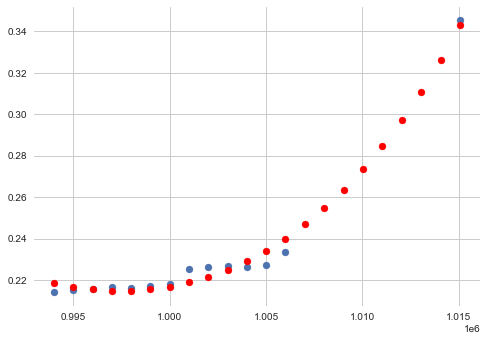

In [144]:
cur_gal_df = pd.concat([full_df_exp, Submission_df_le_exp]) \
    .query("galaxy == 5").sort_values(by = 'galactic year')

plt.scatter(cur_gal_df['galactic year'], cur_gal_df.y)
plt.scatter(cur_gal_df['galactic year'], cur_gal_df.y_pred_exp, color = 'red')


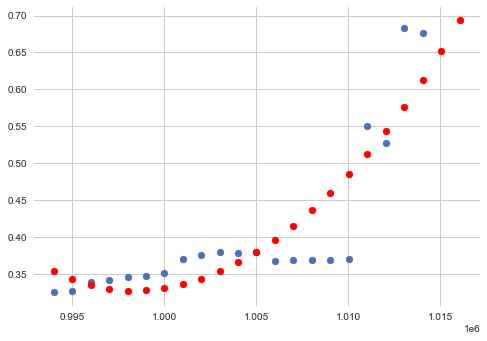

In [145]:
cur_gal_df = pd.concat([full_df_exp, Submission_df_le_exp]) \
    .query("galaxy == 43").sort_values(by = 'galactic year')

plt.scatter(cur_gal_df['galactic year'], cur_gal_df.y)
plt.scatter(cur_gal_df['galactic year'], cur_gal_df.y_pred_exp, color = 'red')


## Train model on full train.csv

In [146]:
full_df_exp

galactic year  galaxy  existence expectancy index  \
0            994009     111                    0.825329   
1            994009      65                    0.881684   
2            994009     160                    0.842679   
3            994009     105                    0.847301   
4            994009      19                    0.838039   
...             ...     ...                         ...   
3139        1014049      23                    0.960942   
3140        1010025     132                    1.204456   
3141        1013042     115                    0.983623   
3142        1010025     129                    1.001081   
3143        1008016      16                    0.917180   

      existence expectancy at birth  Gross income per capita  Income Index  \
0                         74.112839             18438.213872      0.921891   
1                         79.528146             28468.410433      0.745391   
2                         75.586901             22618.238088      0.619596   
3                         81.546139             24156.141071      0.715410   
4                         83.463673             24361.441707      0.876989   
...                             ...                      ...           ...   
3139                      90.641239             37995.921912      0.992208   
3140                      86.536368             46735.170776      1.021275   
3141                      90.777114             34447.535728      0.978358   
3142                      89.694197             38765.344900      0.995559   
3143                      85.598303             42088.245798      0.912835   

      Expected years of education (galactic years)  \
0                                        12.906719   
1                                        12.680997   
2                                        14.539411   
3                                        11.882259   
4                                        15.377155   
...                                            ...   
3139                                     17.919359   
3140                                     17.666915   
3141                                     18.553961   
3142                                     19.798182   
3143                                     17.400791   

      Mean years of education (galactic years)  \
0                                     9.278367   
1                                     9.716420   
2                                    11.950368   
3                                     6.052965   
4                                    12.995889   
...                                        ...   
3139                                 15.256236   
3140                                 14.377467   
3141                                 13.993119   
3142                                 14.835564   
3143                                 11.451926   

      Intergalactic Development Index (IDI)  Education Index  ...  \
0                                  0.701793         0.628931  ...   
1                                  0.860251         0.680485  ...   
2                                  0.814889         0.797904  ...   
3                                  0.830223         0.556905  ...   
4                                  0.757186         0.806460  ...   
...                                     ...              ...  ...   
3139                               0.948178         1.049231  ...   
3140                               1.122299         0.986804  ...   
3141                               1.058407         0.987756  ...   
3142                               1.033855         0.914343  ...   
3143                               0.786881         0.767607  ...   

      Gender Development Index (GDI)  \
0                                NaN   
1                                NaN   
2                                NaN   
3                                NaN   
4                                NaN   
...                              ...   
3

In [147]:
import lightgbm as lgb
lgb_train = lgb.Dataset(full_df_exp.drop('y', axis = 1).values, full_df_exp.y)
gbm_on_full = lgb.train({'objective': 'regression', 'learning_rate': 0.1, 'max_bin': 128},
                    lgb_train,
                    num_boost_round=gbm_exp.best_iteration)

## Filling gaps in submission_df

In [ ]:
#fill_mean_by_galaxy(Submission_df_le)

#scaler = StandardScaler().fit(data)
#data = scaler.transform(data)

## Predict y

In [148]:
Submission_df_le_exp['y_pred'] = gbm_on_full.predict(Submission_df_le_exp)

In [171]:
Submission_df_le_exp

NameError: name 'Submission_df_le_exp' is not defined

In [149]:
Submission_df_le_exp lreg_y_df

galactic year  galaxy  existence expectancy index  \
0          1007012      84                    0.456086   
1          1007012     142                    0.529835   
2          1008016     142                    0.560976   
3          1007012     147                    0.565910   
4          1013042     178                    0.588274   
..             ...     ...                         ...   
885        1016064      58                         NaN   
886        1016064     116                         NaN   
887        1016064      57                         NaN   
888        1016064      61                         NaN   
889        1016064      84                         NaN   

     existence expectancy at birth  Gross income per capita  Income Index  \
0                        51.562543             12236.576447      0.593325   
1                        57.228262              3431.883825      0.675407   
2                        59.379539             27562.914252      0.594624   
3                        59.952390             20352.232905      0.837700   
4                        55.428320             23959.704016      0.520579   
..                             ...                      ...           ...   
885                            NaN                      NaN           NaN   
886                            NaN                      NaN           NaN   
887                            NaN                      NaN           NaN   
888                            NaN                      NaN           NaN   
889                            NaN                      NaN           NaN   

     Expected years of education (galactic years)  \
0                                       10.414164   
1                                        7.239485   
2                                       11.774890   
3                                       11.613621   
4                                       10.392416   
..                                            ...   
885                                           NaN   
886                                           NaN   
887                                           NaN   
888                                           NaN   
889                                           NaN   

     Mean years of education (galactic years)  \
0                                   10.699072   
1                                    5.311122   
2                                    5.937797   
3                                   10.067882   
4                                    6.374637   
..                                        ...   
885                                       NaN   
886                                       NaN   
887                                       NaN   
888                                       NaN   
889                                       NaN   

     Intergalactic Development Index (IDI)  Education Index  ...  \
0                                 0.547114         0.556267  ...   
1                                 0.497688         0.409969  ...   
2                                 0.544744         0.486167  ...   
3                                 0.691641         0.523441  ...   
4                                 0.530676         0.580418  ...   
..                                     ...              ...  ...   
885                                    NaN              NaN  ...   
886                                    NaN              NaN  ...   
887                                    NaN              NaN  ...   
888                                    NaN              NaN  ...   
889                                    NaN              NaN  ...   

     Gender Development Index (GDI)  \
0                               NaN   
1                               NaN   
2                               NaN   
3                               NaN   
4                          0.856158   
..                              ...   
885                             NaN   
886                         

## Plot predictions

In [156]:
import matplotlib.animation as animation
import numpy as np
from pylab import *
from IPython.display import HTML

dpi = 100


def plot_pred_by_galaxy(gal):
    
    plt.clf()
    #plt.figure()
    plt.title(gal)
    cur_gal_df_full= full_df_exp \
        .query("galaxy == @gal").sort_values(by = 'galactic year')

    cur_gal_df_subm= Submission_df_le_exp \
        .query("galaxy == @gal").sort_values(by = 'galactic year')

    full_df_exp

    plt.scatter(cur_gal_df_full['galactic year'], cur_gal_df_full.y)
    plt.scatter(cur_gal_df_subm['galactic year'], cur_gal_df_subm.y_pred, color = 'red')
    

def ani_by_years():
    fig,ax = plt.subplots(figsize = (8,5))

    gals = Submission_df_le_exp.galaxy.unique()
    ani = animation.FuncAnimation(fig,plot_pred_by_galaxy, gals)
    writer = animation.writers['ffmpeg'](fps=1)

    ani.save('prediction.mp4',writer=writer,dpi=dpi)
    return ani
#HTML(ani.to_html5_video())

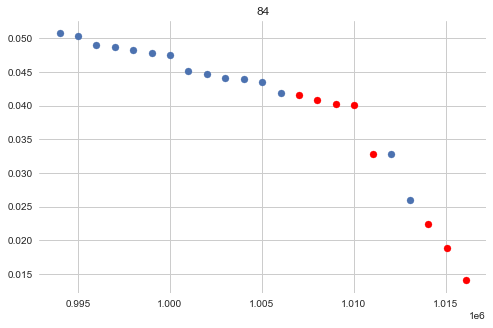

In [157]:
ani_by_years()

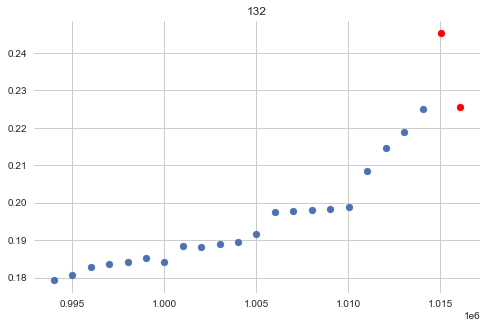

In [151]:
HTML(ani_by_years().to_html5_video())

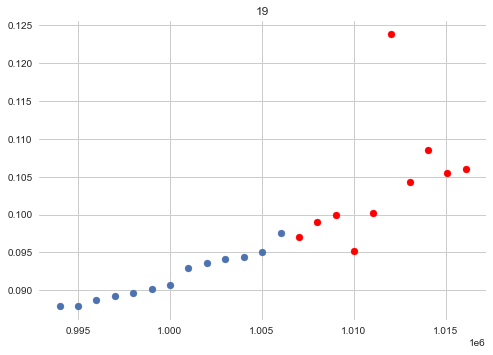

In [152]:
plot_pred_by_galaxy(19)

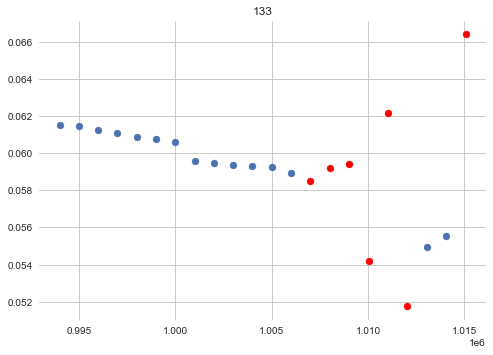

In [154]:
plot_pred_by_galaxy(133)

## Energy allocation 

Description Data Recieved

The solutions are evaluated on two criteria: predicted future Index values and allocated energy from a newly discovered star

1) Index predictions are evaluated using RMSE metric

2) Energy allocation is also evaluated using RMSE metric and has a set of known factors that need to be taken into account.

Every galaxy has a certain limited potential for improvement in the index described by the following function:

Potential for increase in the Index = -np.log(Index+0.01)+3

Likely index increase dependent on potential for improvement and on extra energy availability is described by the following function:

Likely increase in the Index = extra energy * Potential for increase in the Index **2 / 1000

There are also several constraints:

in total there are 50000 zillion DSML available for allocation and no galaxy at a point in time should be allocated more than 100 zillion DSML or less than 0 zillion DSML. Galaxies with low existence expectancy index below 0.7 should be allocated at least 10% of the total energy available in the foreseeable future

3) Leaderboard is based on a combined scaled metric:

80% prediction task RMSE + 20% optimization task RMSE * lambda where lambda is a normalizing factor

4) Leaderboard is 80% public and 20% private

5) The submission should be in the following format:

- in total there are 50000 zillion DSML available for allocation 
- and no galaxy at a point in time should be allocated more than 100 zillion DSML or less than 0 zillion DSML. 
- Galaxies with low existence expectancy index below 0.7 should be allocated at least 10% of the total energy available in the foreseeable future

Key factors:
- **Potential for increase in the Index** = -np.log(Index+0.01)+3

- **Likely increase in the Index** = extra energy * (Potential for increase in the Index **2) / 1000

Имеет смысл вкладывать больше туда, где выше вероятное увеличение индекса. При этом вероятное увеличение индекса зависит от вложенной энергии.

То есть нужно вкладывать туда, где выше потенциал увеличения, и при этом чем выше потенциал, тем больше вкладывать.

Задача: максимизировать вероятное увеличение индекса по всем галактикам с учетом ограничений: 
- всего доступно 50 000 для аллокации
- в любой момент времени в любой галактике DSML в интервале [0,100], не иначе
- Галактикам с низким индексом продолжительности существования ниже 0,7 следует выделять не менее 10% от общей энергии, доступной в обозримом будущем


**at least 10% of the total energy will be consumed by galaxies in need with existence expectancy index below 0,7.**

Павел Егоров, [31 мая 2020 г., 14:43:03]:

То есть я максимизирую сумму Likely increase in the Index

при условиях

1) сумма всей аллоцированной энергии < 50000
2) на low-eei галактики аллоцировано не менее 10% ресурсов
3) на каждую в каждый момент времени от 0 до 100

In [159]:
from scipy.optimize import minimize

ss = pd.DataFrame({
    'Index':Submission_df_le_exp.index,
    'year': Submission_df_le_exp['galactic year'],
    'galaxy': Submission_df_le_exp['galaxy'],
    'pred':Submission_df_le_exp['y_pred_exp'], # EXP SIMPLY FUC*ING EXP
    'opt_pred':0,
    'eei':Submission_df_le_exp['existence expectancy index'], # So we can split into low and high EEI galaxies
    'p2':(-np.log(Submission_df_le_exp['y_pred']+0.01)+3)**2
})

In [160]:
ss.isna().sum()

Index       0
year        0
galaxy      0
pred        0
opt_pred    0
eei         5
p2          0
dtype: int64

In [161]:
fill_mean_by_galaxy(ss)

In [162]:
ss.isna().sum()

Index       0
year        0
galaxy      0
pred        0
opt_pred    0
eei         0
p2          0
dtype: int64

In [164]:
TOTAL_YEAR_DSML = 10000
TOTAL_DSML_AVAILABLE = 49999


#for year in ss.year.unique()[:2]:
cur_year_df = ss#.query("year == @year")
print()
print('-----------------------------------')
print('Total DSML available', TOTAL_DSML_AVAILABLE)

def calc_wellbeing(opt_pred):
    return np.sum(opt_pred * (cur_year_df.p2)/ 1000)

def objective(opt_pred):
    return -calc_wellbeing(opt_pred)

#constraints
def total_energy_constraint(opt_pred):
    return TOTAL_DSML_AVAILABLE - np.sum(opt_pred)

def energy_for_low_eei_constraint(opt_pred):
    cur_year_df.opt_pred = opt_pred

    #return cur_year_df.query("eei < 0.7").opt_pred.sum() - \
    #    (TOTAL_DSML_AVAILABLE - cur_year_df.query("eei >= 0.7").opt_pred.sum())*0.1 

    #at least 10% of the total energy will be consumed 
    #by galaxies in need with existence expectancy index below 0,7.
    return cur_year_df.query("eei < 0.7").opt_pred.sum() - \
        (cur_year_df.opt_pred.sum())*0.1 

cons = ({'type': 'ineq', 'fun': total_energy_constraint},
        {'type': 'ineq', 'fun': energy_for_low_eei_constraint})

#initial values
x0 = (cur_year_df['p2']*TOTAL_YEAR_DSML/cur_year_df['p2'].sum()).clip(0, 100).values

#bounds 
bnds = ((0,100),)
for i in range(len(cur_year_df)-1): 
    bnds = ((0,100),) + bnds   

#solver
sol = minimize(objective, x0, 
               method = 'slsqp', 
               constraints = cons, 
               bounds = bnds, 
               options = {'disp': True})

y_predOpt = sol.x
cur_year_df.opt_pred = y_predOpt

# updating source df with allocation for current year
ss.update(cur_year_df['opt_pred'])



#updating total dsml available
#TOTAL_DSML_AVAILABLE = TOTAL_DSML_AVAILABLE - y_predOpt.sum()




-----------------------------------
Total DSML available 49999
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1831.527808309584
            Iterations: 101
            Function evaluations: 90092
            Gradient evaluations: 101


In [165]:
print('Total energy allocated', ss.opt_pred.sum())
print('Total energy allocated for high-eei galaxies:', str(ss.query("eei >= 0.7").opt_pred.sum()))
print('Total energy allocated for low-eei galaxies:', str(ss.query("eei < 0.7").opt_pred.sum()), \
     '(' + str(round((ss.query("eei < 0.7").opt_pred.sum()/ss.opt_pred.sum())*100,1)), '% of total energy allocated).')
print('Maximum energy of each galaxy at any given time does not exceed', ss.opt_pred.max())

Total energy allocated 49998.99999704324
Total energy allocated for high-eei galaxies: 43393.76682660179
Total energy allocated for low-eei galaxies: 6605.233170441447 (13.2 % of total energy allocated).
Maximum energy of each galaxy at any given time does not exceed 99.9999999947329


In [167]:
ss.Index = pd.to_numeric(ss.Index, downcast = 'integer')
ss[['Index', 'pred', 'opt_pred']]

Index      pred    opt_pred
0        0  0.038919   98.617875
1        1  0.034536   99.009075
2        2  0.032865   99.011971
3        3  0.034852   98.981242
4        4  0.029345  100.000000
..     ...       ...         ...
885    885  0.024607  100.000000
886    886  0.028738  100.000000
887    887  0.066323   51.536206
888    888  0.061281   57.115377
889    889  0.024234  100.000000

[890 rows x 3 columns]

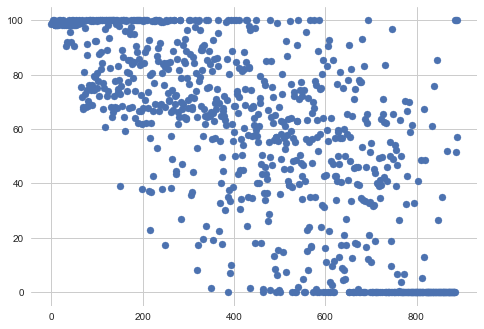

In [168]:
plt.scatter(ss.index, ss.opt_pred)

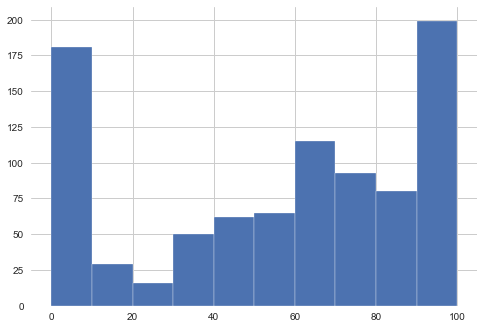

In [169]:
ss.opt_pred.hist()

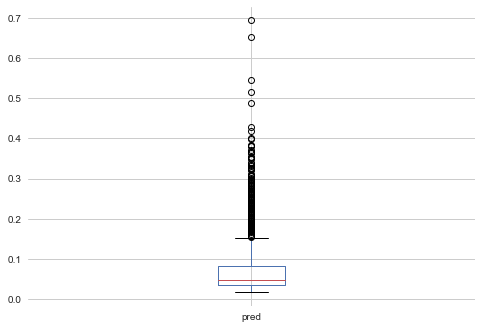

In [172]:
ss.boxplot(column = ['pred'])

In [173]:
ss[['Index', 'pred', 'opt_pred']].to_csv('submission.csv', index=False)

# Data Cleaning

# SANDBOX

In [ ]:
msno.heatmap(train_df[train_df.columns[:11].values])

In [ ]:
msno.heatmap(train_df)

In [ ]:
msno.dendrogram(train_df)

In [ ]:
train_df['missing_frac'] = train_df.isnull().sum(axis=1)/len(train_df.columns)
train_df_agg_misfrac_std_per_galaxy = train_df.groupby(['galaxy'])['missing_frac'].std()
train_df_agg_y_std_per_galaxy = train_df.groupby(['galaxy'])['y'].std()


In [ ]:
train_df_agg_y_std_per_galaxy

In [ ]:
import numpy as np
plt.figure()
x = np.sort(train_df_agg_misfrac_std_per_galaxy.values)
y = np.arange(1, len(x) + 1) / len(x)

_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Std of missing values in galaxy')
_ = plt.ylabel('ECDF')

plt.margins(0.02)

**About 20% of galaxies have std of missing value per row less than 0.33**

In [ ]:
low_misfrac_std_galaxies = train_df_agg_misfrac_std_per_galaxy[
    train_df_agg_misfrac_std_per_galaxy <= 0.33].index
high_misfrac_std_galaxies = train_df_agg_misfrac_std_per_galaxy[
    train_df_agg_misfrac_std_per_galaxy > 0.33].index


In [ ]:
import plotly.express as px

#df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(train_df, 
              x="galactic year", 
              y="y", 
              color='galaxy')
fig.show()

In [ ]:
train_df.groupby('galactic year')['missing_frac'].mean()

In [ ]:
pd.DataFrame(train_df.groupby('galactic year')['missing_frac'].mean().reset_index())

In [ ]:
pd.DataFrame(train_df.groupby('galactic year')['missing_frac'].mean().reset_index())

In [ ]:
import plotly.express as px

#df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(train_df, 
              x="galactic year", 
              y="y",
             color = 'galaxy')
fig.show()

In [ ]:
import plotly.express as px

train_df_avg_missing_by_year = pd.DataFrame(train_df.groupby('galactic year')['missing_frac'].mean().reset_index())

#df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(train_df_avg_missing_by_year, 
              x="galactic year", 
              y="missing_frac")
fig.show()

In [ ]:
import plotly.express as px

#df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(train_df[train_df['galaxy'].isin(low_misfrac_std_galaxies)], 
              x="galactic year", 
              y="y", 
              color='galaxy')
fig.show()

In [ ]:
#df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(train_df[train_df['galaxy'].isin(high_misfrac_std_galaxies)], 
              x="galactic year", 
              y="y", 
              color='galaxy')
fig.show()

In [ ]:
train_df[['galactic year', 'y']].plot()

In [ ]:
train_df['y'].plot()